In [70]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.transforms import GaussianBlur
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
class coldDiff:
    def __init__(self, steps=300, size=28, loss_type='L2'):
        self.steps = steps
        self.size = size
        self.loss_type = loss_type
        
    def blur(self, x0, t, base_sigma=1.0):
        sigma_t = torch.sqrt(t*base_sigma**2).detach().cpu().numpy()
        x0_cpu = x0.detach().cpu().numpy()
        blurred_imgs = [gaussian_filter(x0_cpu[i], sigma=(0, sigma_t[i], sigma_t[i])) for i in range(len(sigma_t))]
        return torch.from_numpy(np.stack(blurred_imgs)).to(device)
        # return GaussianBlur(5, sigma_t)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.steps, size=(n,))
    
    def sample(self, model, batch_size):
        output_shape = (batch_size, 1, 28, 28)
        t = self.steps
        model.eval()
        #x_prev = x_t
        # For now just use a black image
        x_prev = torch.zeros(output_shape).to(device)
        for s in tqdm(range(t, 0, -1)):
            s_ = (torch.ones(batch_size)*s).long().to(device)
            pred_x0 = model(x_prev, s_)
            x_prev = x_prev - self.blur(pred_x0, s_) + self.blur(pred_x0, s_-1)
        return pred_x0

In [73]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [74]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [75]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [76]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [77]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [78]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.detach().cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [79]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

In [80]:
np.random.seed(32)

def split_indices(n, val_pct):
    n_val = int(val_pct*n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

938


 43%|██████████████████████████████████▏                                             | 128/300 [00:08<00:11, 15.27it/s]


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [00:17<00:02, 15.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:19<00:00, 15.20it/s]


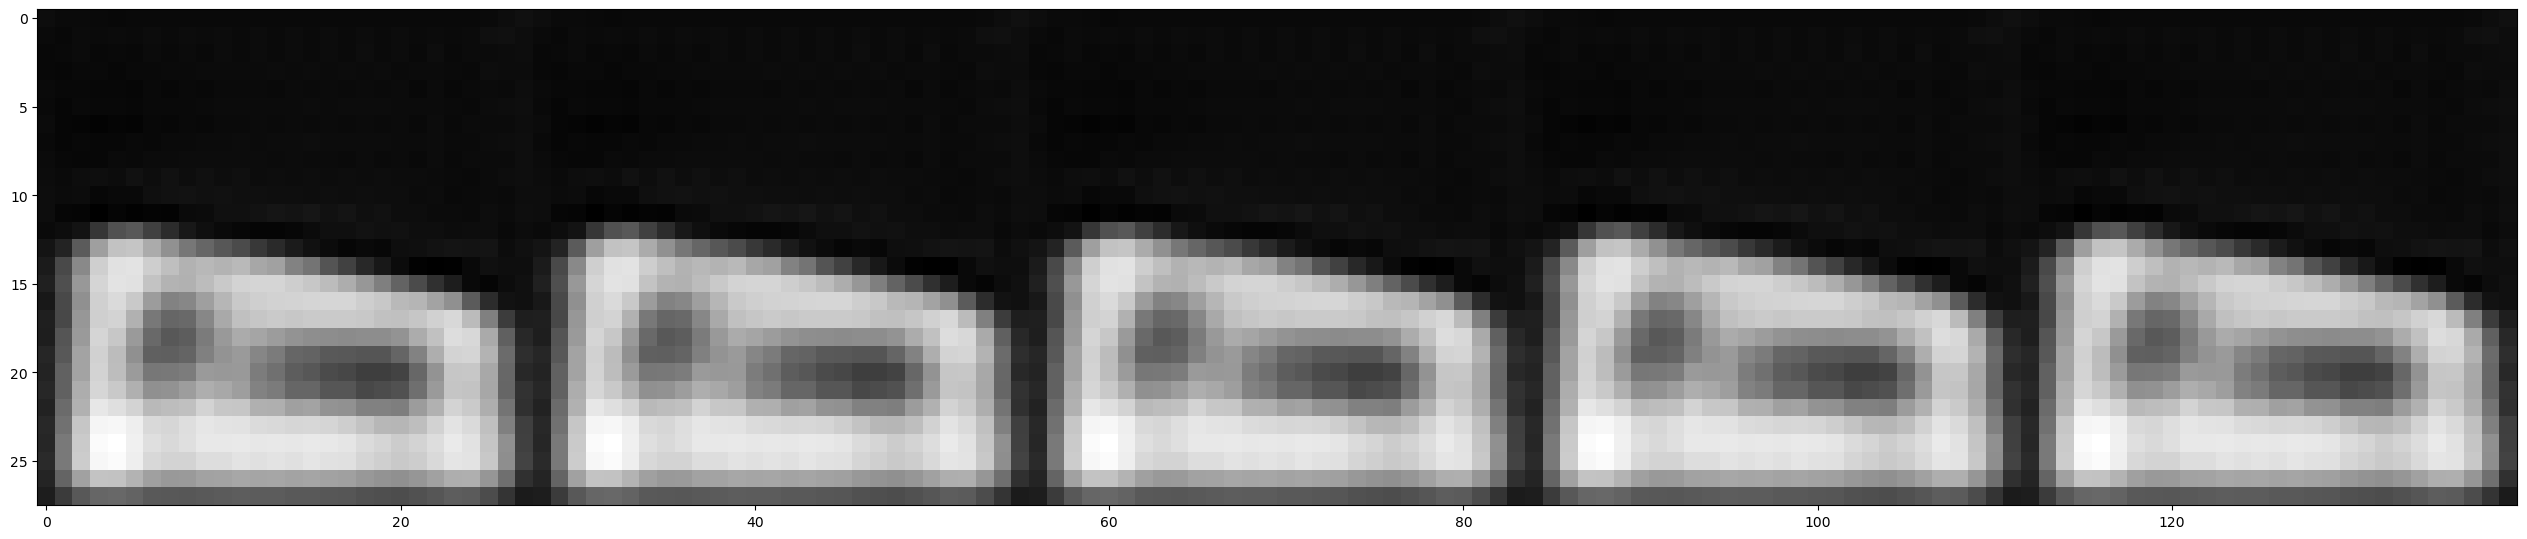

  1%|▊                                                                            | 1/100 [47:44<78:45:56, 2864.21s/it]

Epoch [1/100] | Train Loss: 0.2479 | Validation Loss: 0.1998


  2%|█▌                                                                         | 2/100 [1:34:46<77:18:11, 2839.71s/it]

Epoch [2/100] | Train Loss: 0.1846 | Validation Loss: 0.1756


  3%|██▎                                                                        | 3/100 [2:21:46<76:16:08, 2830.60s/it]

Epoch [3/100] | Train Loss: 0.1666 | Validation Loss: 0.1646



 45%|████████████████████████████████████                                            | 135/300 [00:07<00:08, 18.38it/s]


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [00:14<00:01, 18.62it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.54it/s]


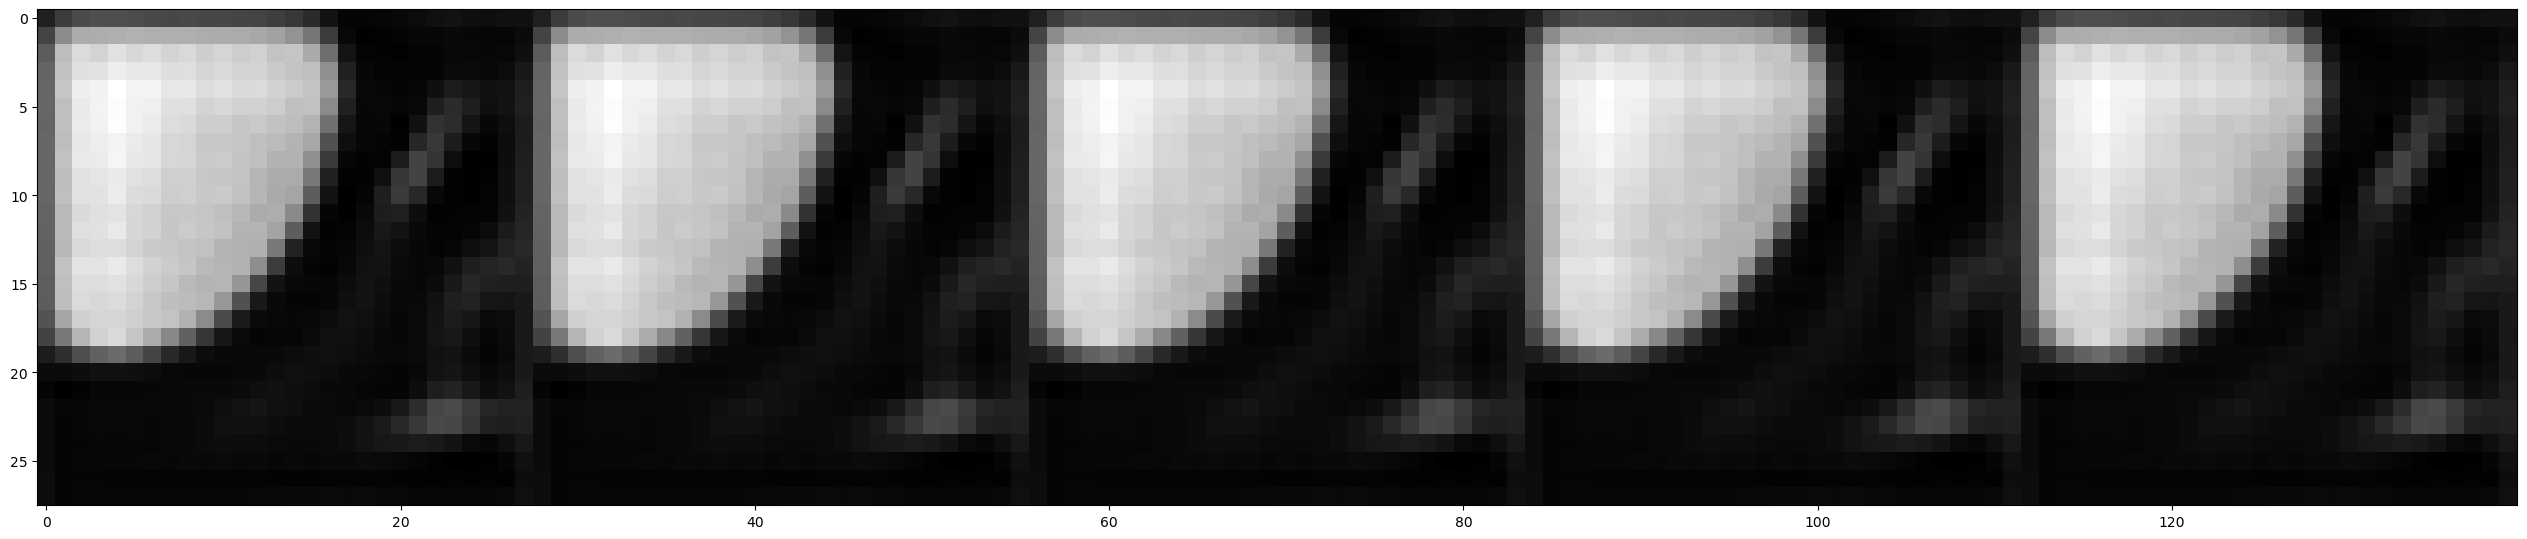

  4%|███                                                                        | 4/100 [3:09:06<75:35:08, 2834.46s/it]

Epoch [4/100] | Train Loss: 0.1551 | Validation Loss: 0.1520


  5%|███▊                                                                       | 5/100 [3:55:52<74:31:19, 2823.99s/it]

Epoch [5/100] | Train Loss: 0.1479 | Validation Loss: 0.1467


  6%|████▌                                                                      | 6/100 [4:42:42<73:37:03, 2819.40s/it]

Epoch [6/100] | Train Loss: 0.1427 | Validation Loss: 0.1428



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.77it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:15<00:02, 17.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.32it/s]


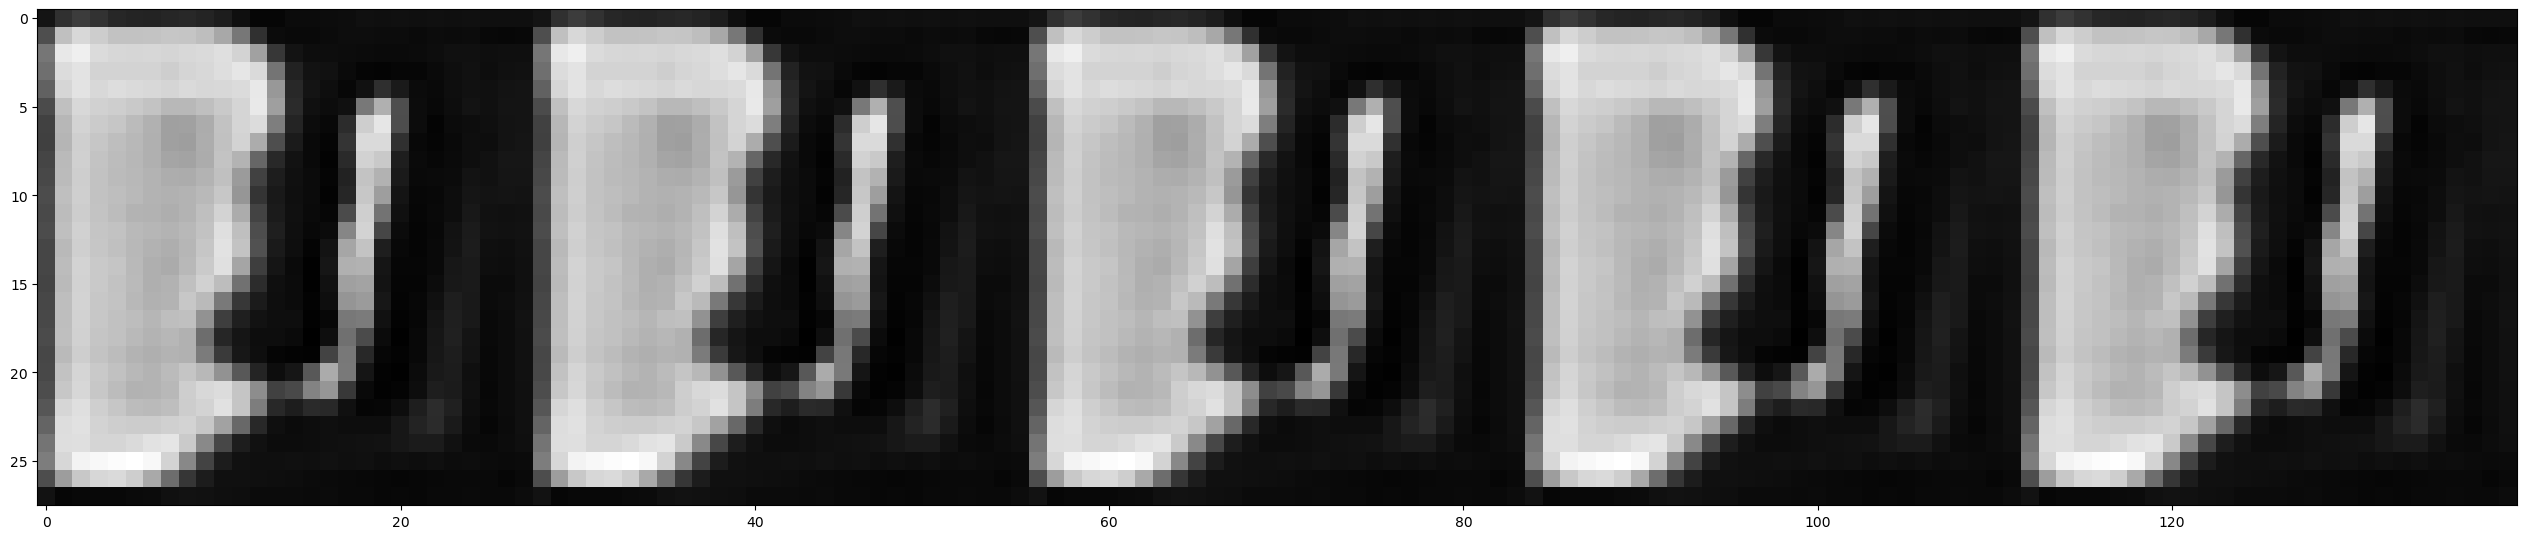

  7%|█████▎                                                                     | 7/100 [5:29:50<72:54:29, 2822.25s/it]

Epoch [7/100] | Train Loss: 0.1381 | Validation Loss: 0.1385


  8%|██████                                                                     | 8/100 [6:17:58<72:39:24, 2843.09s/it]

Epoch [8/100] | Train Loss: 0.1350 | Validation Loss: 0.1332


  9%|██████▊                                                                    | 9/100 [7:06:07<72:13:29, 2857.24s/it]

Epoch [9/100] | Train Loss: 0.1327 | Validation Loss: 0.1327



 44%|██████████████████████████████████▉                                             | 131/300 [00:07<00:09, 17.83it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [00:14<00:01, 18.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.01it/s]


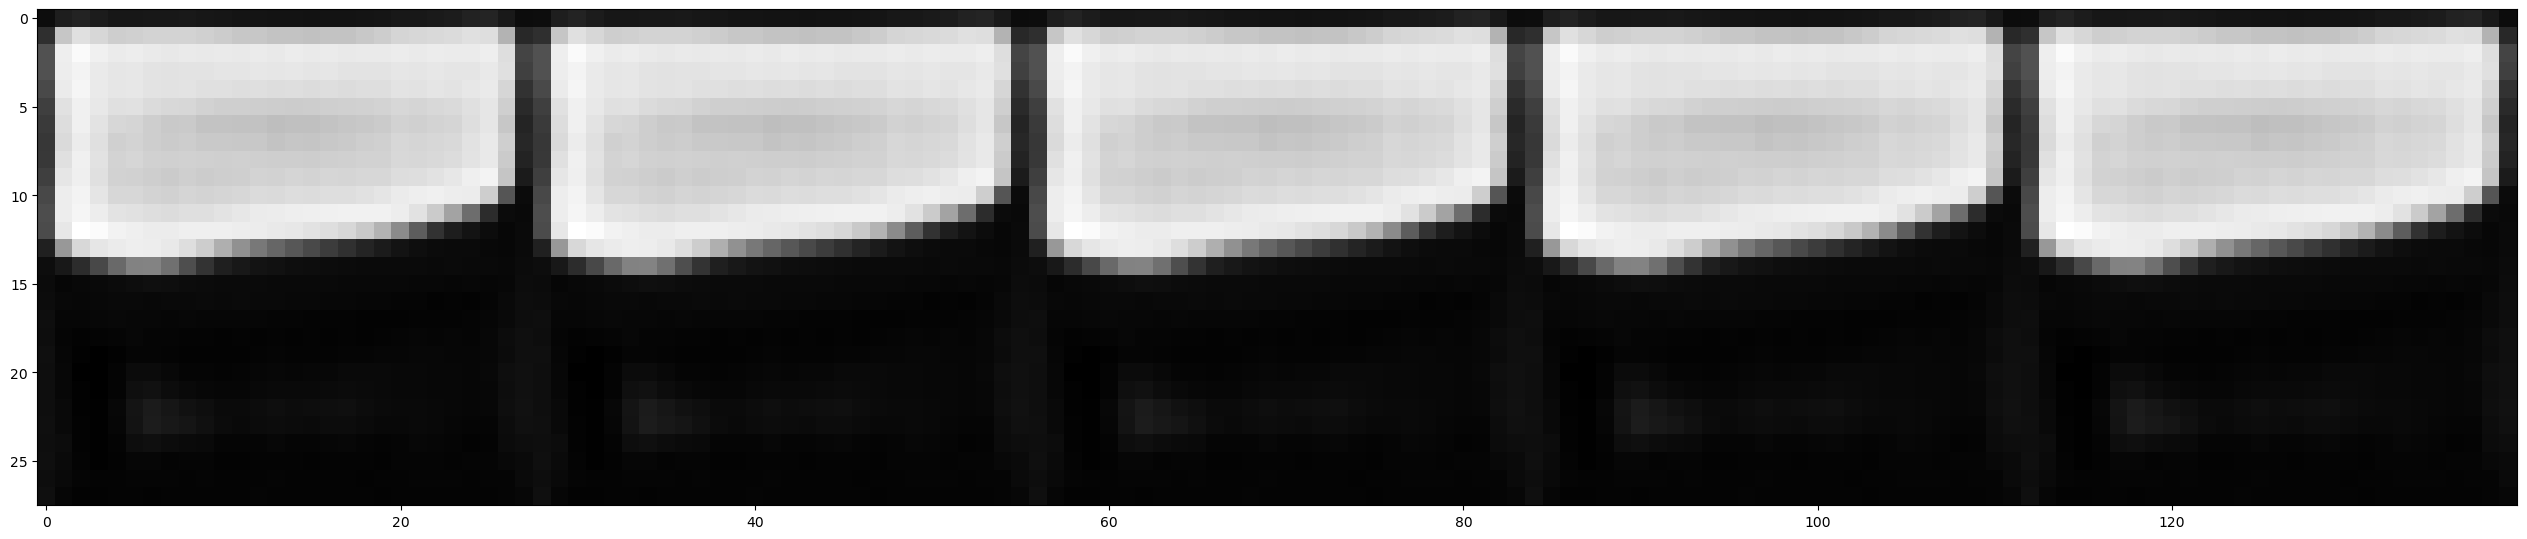

 10%|███████▍                                                                  | 10/100 [7:54:33<71:48:33, 2872.37s/it]

Epoch [10/100] | Train Loss: 0.1309 | Validation Loss: 0.1275


 11%|████████▏                                                                 | 11/100 [8:41:33<70:37:05, 2856.47s/it]

Epoch [11/100] | Train Loss: 0.1276 | Validation Loss: 0.1255


 12%|████████▉                                                                 | 12/100 [9:28:38<69:35:28, 2846.91s/it]

Epoch [12/100] | Train Loss: 0.1262 | Validation Loss: 0.1232



 48%|██████████████████████████████████████▋                                         | 145/300 [00:07<00:08, 18.81it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [00:15<00:00, 20.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.10it/s]


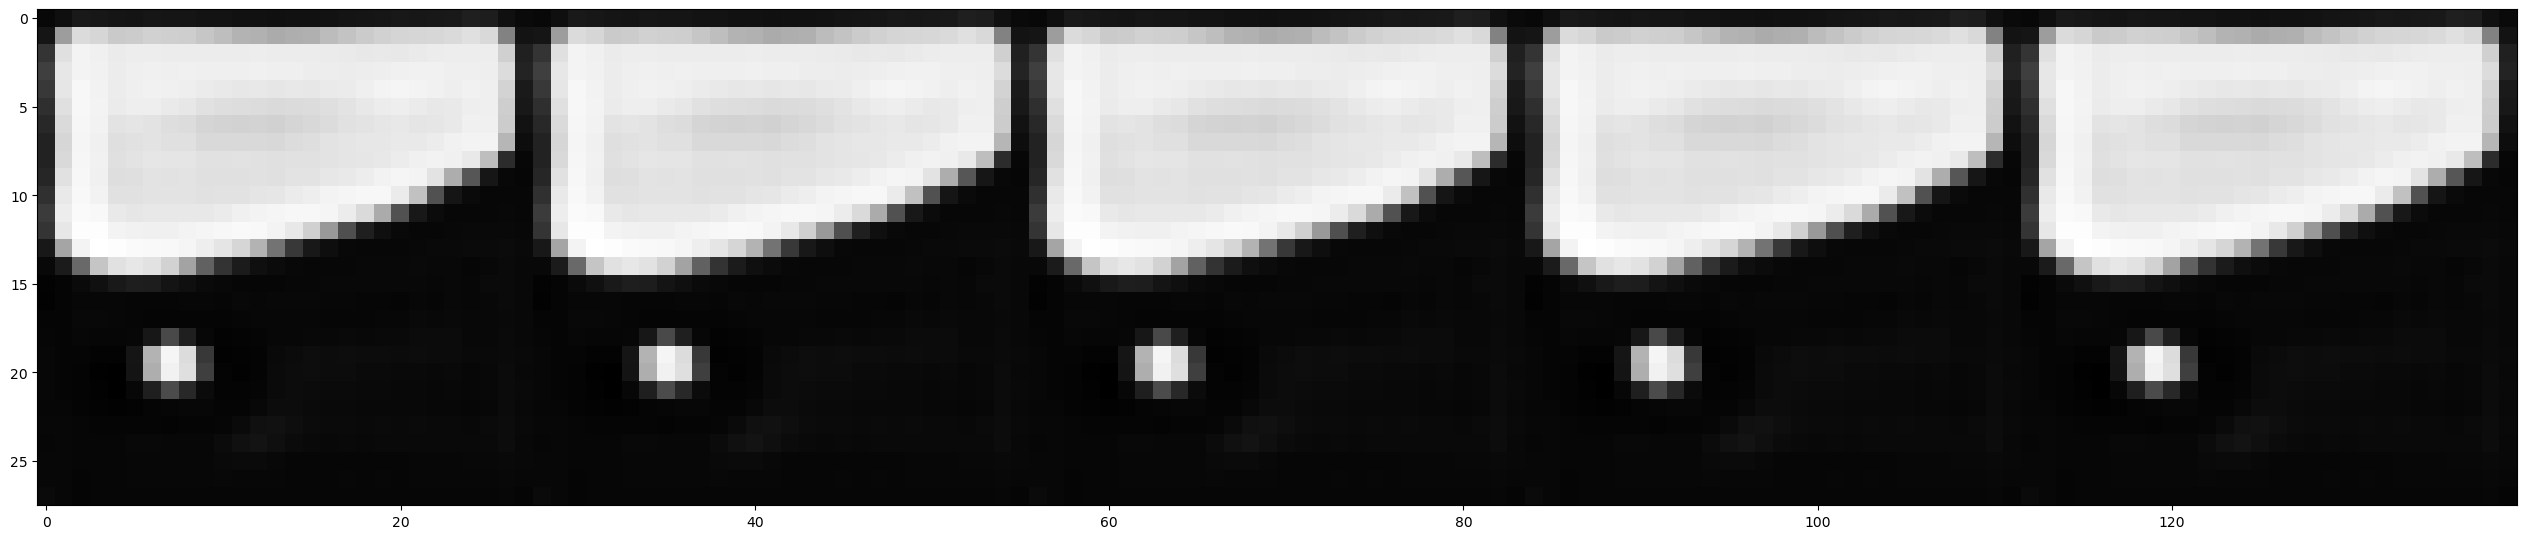

 13%|█████████▍                                                               | 13/100 [10:47:24<82:33:25, 3416.15s/it]

Epoch [13/100] | Train Loss: 0.1250 | Validation Loss: 0.1225


 14%|██████████▏                                                              | 14/100 [11:40:29<79:56:17, 3346.25s/it]

Epoch [14/100] | Train Loss: 0.1236 | Validation Loss: 0.1254


 15%|██████████▉                                                              | 15/100 [12:33:11<77:41:56, 3290.78s/it]

Epoch [15/100] | Train Loss: 0.1225 | Validation Loss: 0.1251



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.74it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.42it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.82it/s]


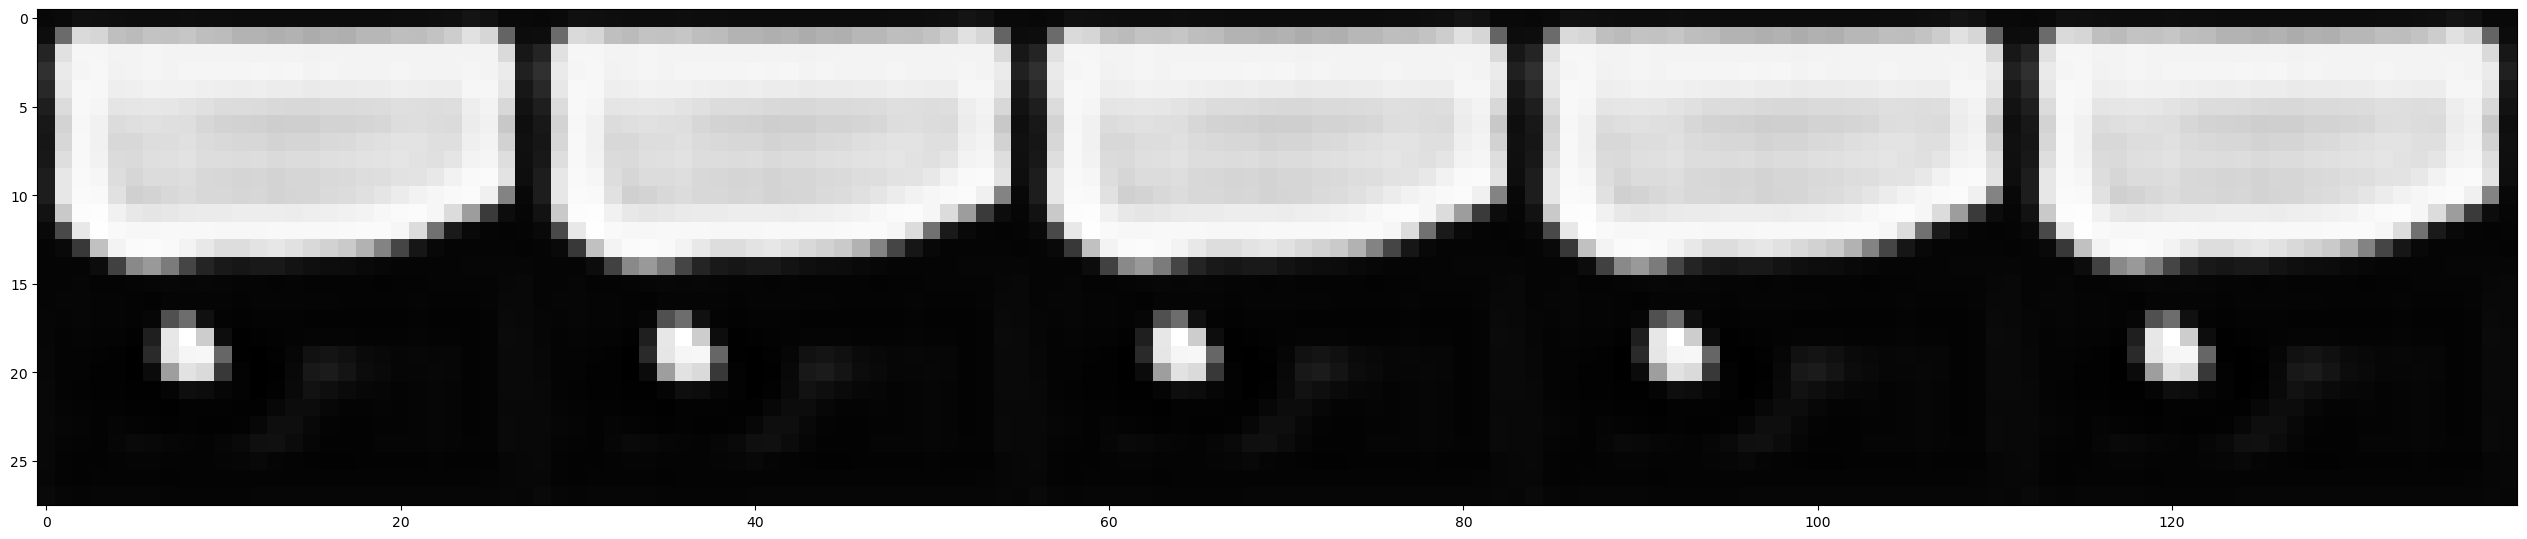

 16%|███████████▋                                                             | 16/100 [13:26:38<76:11:33, 3265.39s/it]

Epoch [16/100] | Train Loss: 0.1208 | Validation Loss: 0.1232


 17%|████████████▍                                                            | 17/100 [14:15:15<72:52:24, 3160.78s/it]

Epoch [17/100] | Train Loss: 0.1197 | Validation Loss: 0.1164


 18%|████████████▉                                                           | 18/100 [16:47:54<113:03:00, 4963.18s/it]

Epoch [18/100] | Train Loss: 0.1187 | Validation Loss: 0.1260



 44%|███████████████████████████████████▍                                            | 133/300 [00:07<00:08, 18.62it/s]


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [00:14<00:01, 18.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.54it/s]


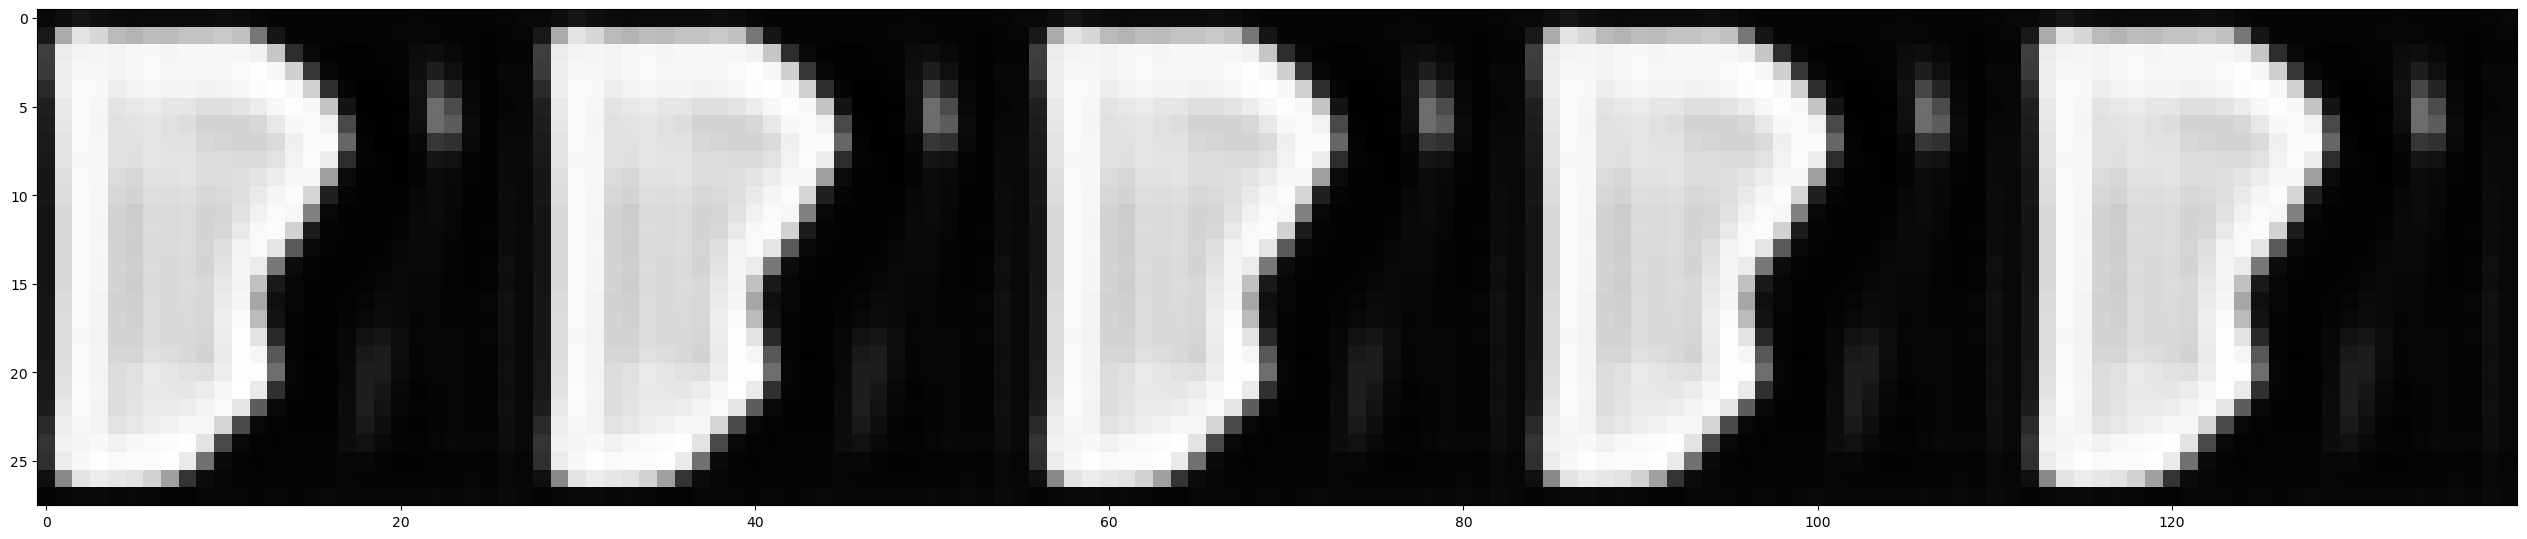

 19%|█████████████▊                                                           | 19/100 [17:36:53<97:59:28, 4355.17s/it]

Epoch [19/100] | Train Loss: 0.1178 | Validation Loss: 0.1221


 20%|██████████████▍                                                         | 20/100 [22:34:39<186:55:29, 8411.62s/it]

Epoch [20/100] | Train Loss: 0.1171 | Validation Loss: 0.1189


 21%|███████████████                                                         | 21/100 [23:23:51<148:37:48, 6773.02s/it]

Epoch [21/100] | Train Loss: 0.1166 | Validation Loss: 0.1163



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.77it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.84it/s]


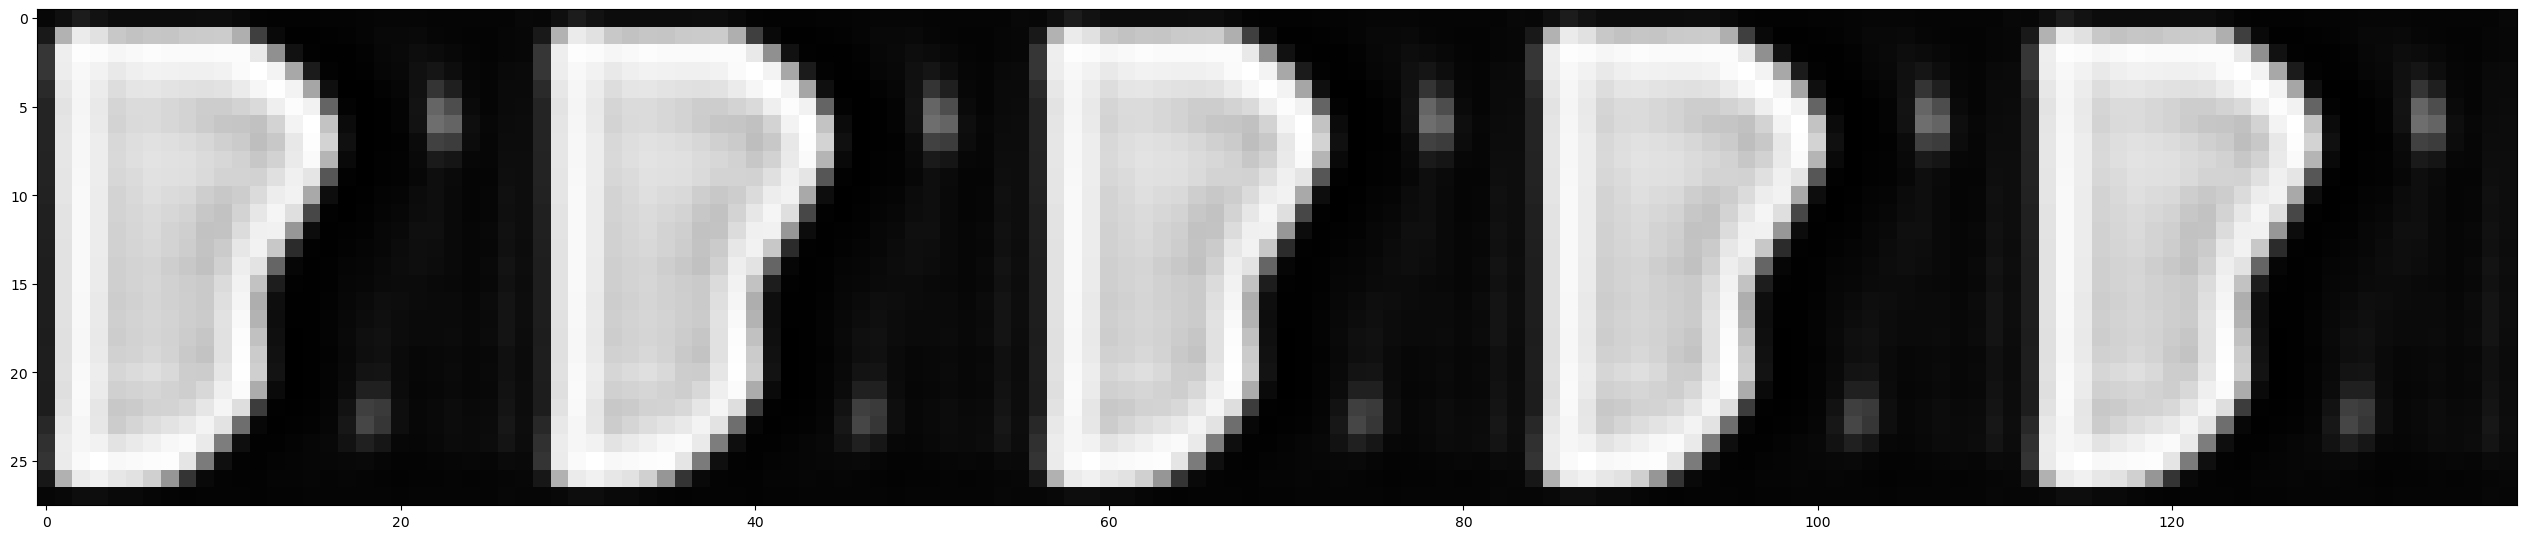

 22%|███████████████▊                                                        | 22/100 [24:14:54<122:37:27, 5659.59s/it]

Epoch [22/100] | Train Loss: 0.1159 | Validation Loss: 0.1123


 23%|████████████████▌                                                       | 23/100 [25:03:26<103:24:59, 4835.05s/it]

Epoch [23/100] | Train Loss: 0.1144 | Validation Loss: 0.1177


 24%|█████████████████▌                                                       | 24/100 [25:51:47<89:49:17, 4254.71s/it]

Epoch [24/100] | Train Loss: 0.1142 | Validation Loss: 0.1166



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.21it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 18.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.23it/s]


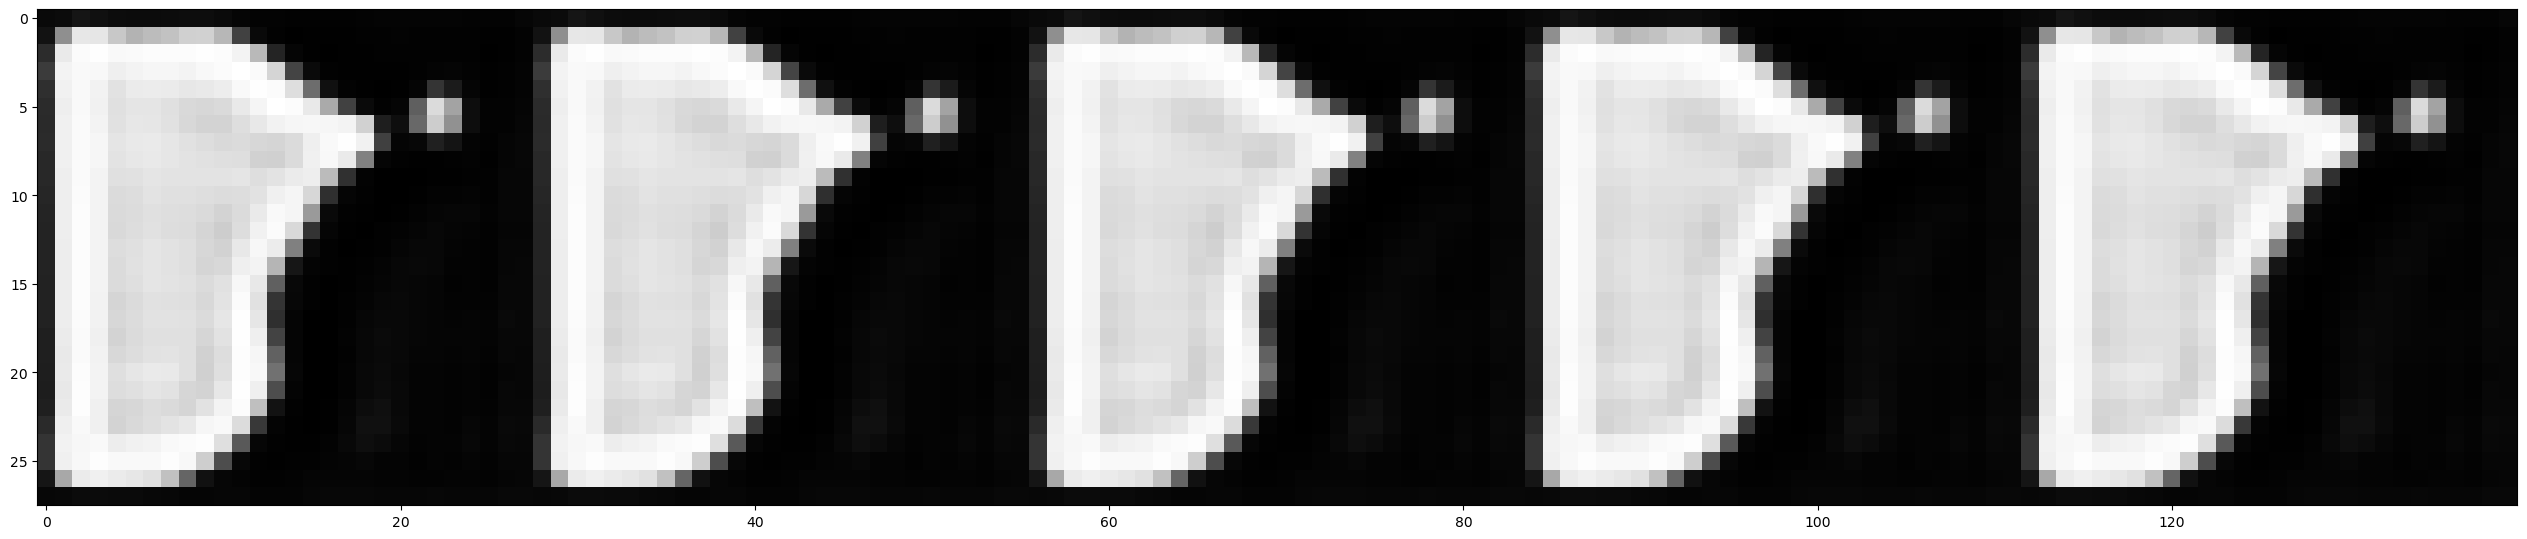

 25%|██████████████████▎                                                      | 25/100 [26:40:24<80:16:24, 3853.13s/it]

Epoch [25/100] | Train Loss: 0.1124 | Validation Loss: 0.1124


 26%|██████████████████▉                                                      | 26/100 [27:27:33<72:53:32, 3546.12s/it]

Epoch [26/100] | Train Loss: 0.1121 | Validation Loss: 0.1143


 27%|███████████████████▋                                                     | 27/100 [28:14:41<67:32:16, 3330.64s/it]

Epoch [27/100] | Train Loss: 0.1113 | Validation Loss: 0.1078



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.41it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 18.32it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.53it/s]


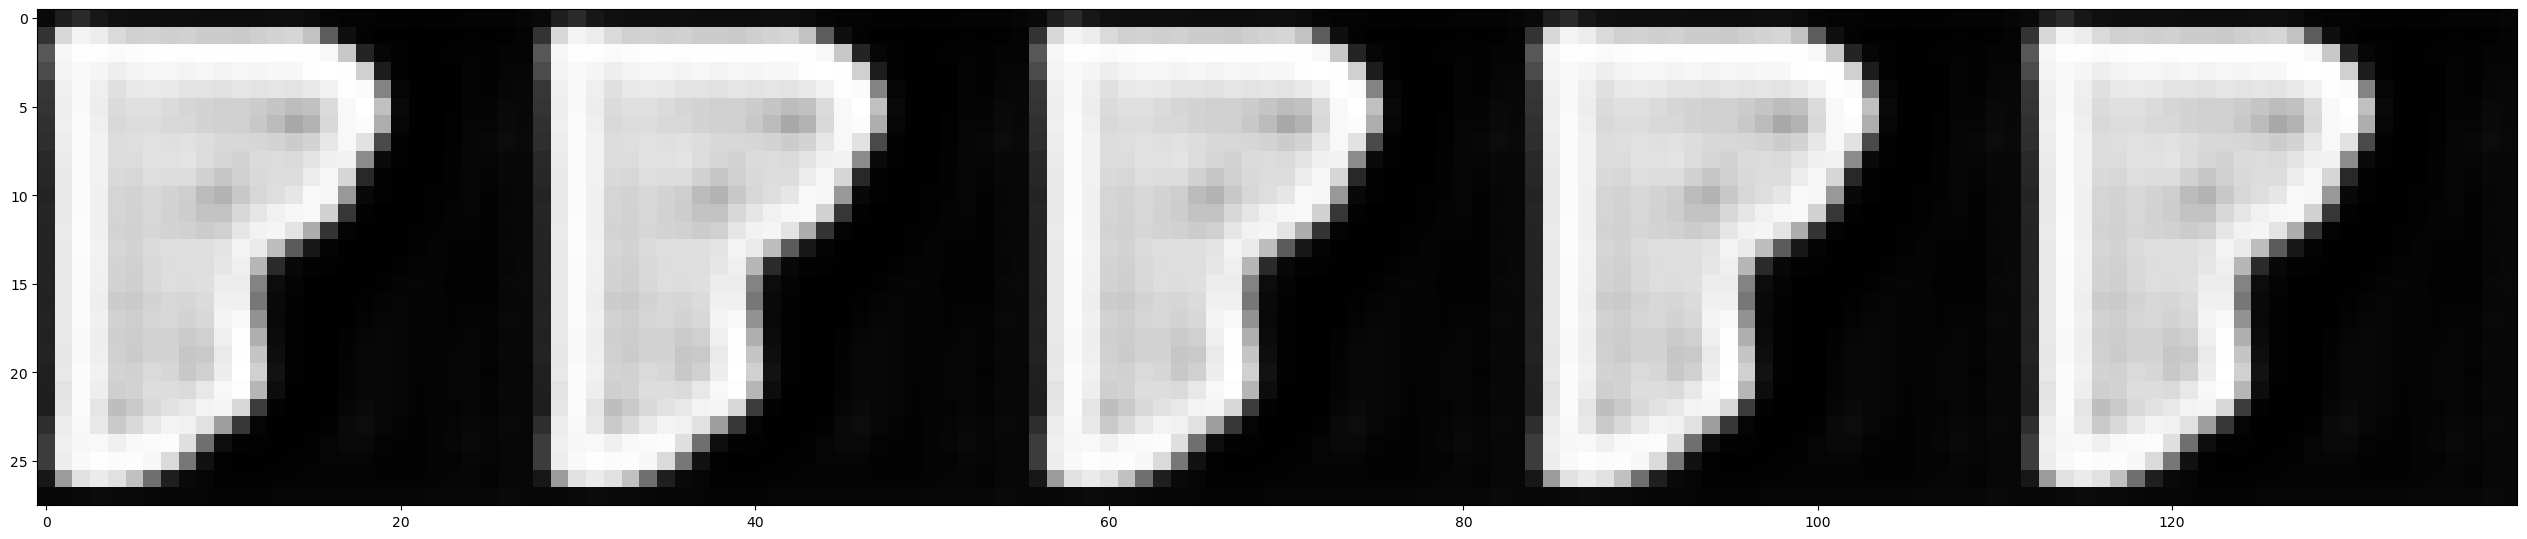

 28%|████████████████████▍                                                    | 28/100 [29:02:14<63:44:46, 3187.32s/it]

Epoch [28/100] | Train Loss: 0.1100 | Validation Loss: 0.1076


 29%|█████████████████████▏                                                   | 29/100 [29:49:24<60:44:52, 3080.18s/it]

Epoch [29/100] | Train Loss: 0.1085 | Validation Loss: 0.1042


 30%|█████████████████████▉                                                   | 30/100 [30:36:39<58:27:24, 3006.35s/it]

Epoch [30/100] | Train Loss: 0.1068 | Validation Loss: 0.1103



 44%|██████████████████████████████████▉                                             | 131/300 [00:07<00:09, 17.57it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:14<00:02, 17.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.09it/s]


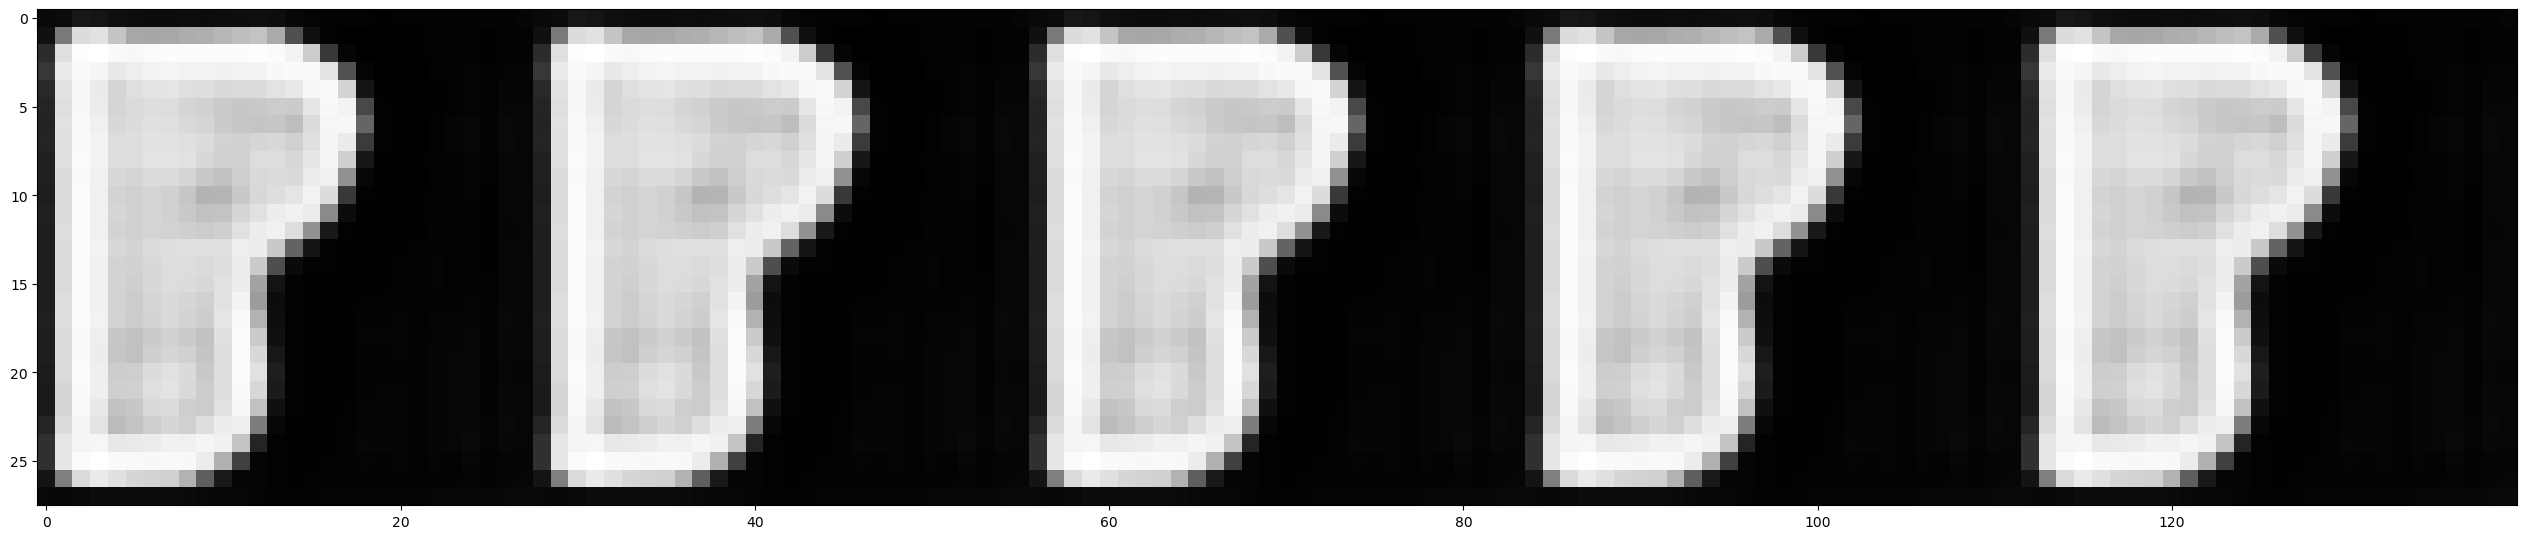

 31%|██████████████████████▋                                                  | 31/100 [31:24:07<56:42:42, 2958.88s/it]

Epoch [31/100] | Train Loss: 0.1065 | Validation Loss: 0.1064


 32%|███████████████████████                                                 | 32/100 [36:44:51<148:10:37, 7844.66s/it]

Epoch [32/100] | Train Loss: 0.1041 | Validation Loss: 0.0996


 33%|███████████████████████▍                                               | 33/100 [41:14:04<192:23:11, 10337.18s/it]

Epoch [33/100] | Train Loss: 0.1029 | Validation Loss: 0.0982



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:10, 16.68it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:15<00:02, 15.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 16.68it/s]


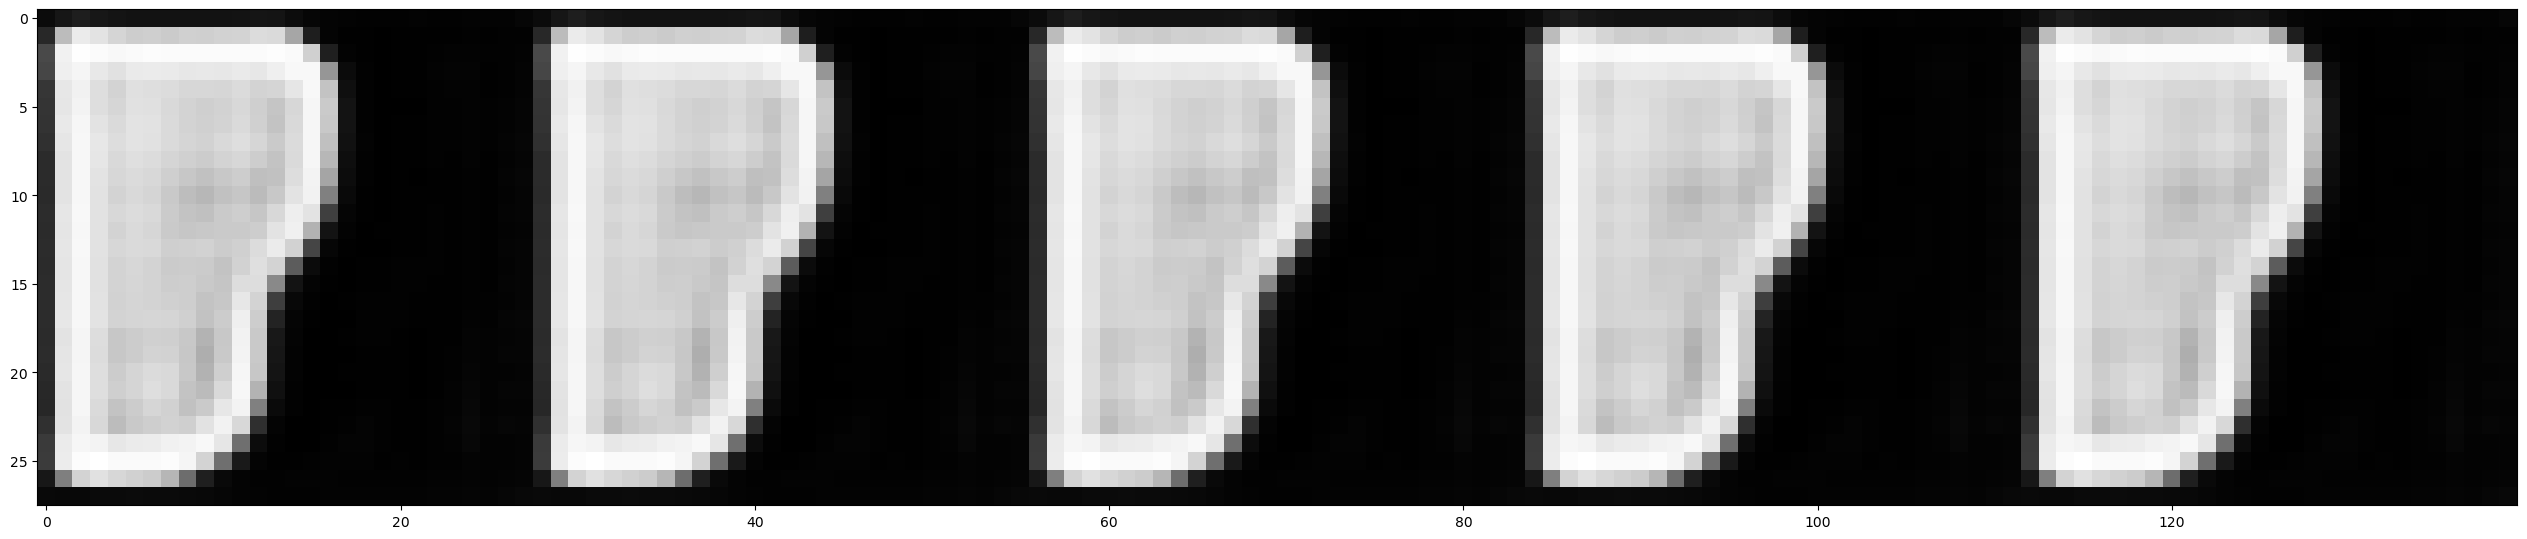

 34%|████████████████████████▍                                               | 34/100 [42:05:19<149:34:25, 8158.57s/it]

Epoch [34/100] | Train Loss: 0.1009 | Validation Loss: 0.1000


 35%|█████████████████████████▏                                              | 35/100 [42:55:05<119:17:08, 6606.59s/it]

Epoch [35/100] | Train Loss: 0.0997 | Validation Loss: 0.1076


 36%|██████████████████████████▎                                              | 36/100 [43:44:12<97:56:07, 5508.87s/it]

Epoch [36/100] | Train Loss: 0.0978 | Validation Loss: 0.1000



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.97it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:14<00:02, 17.41it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.65it/s]


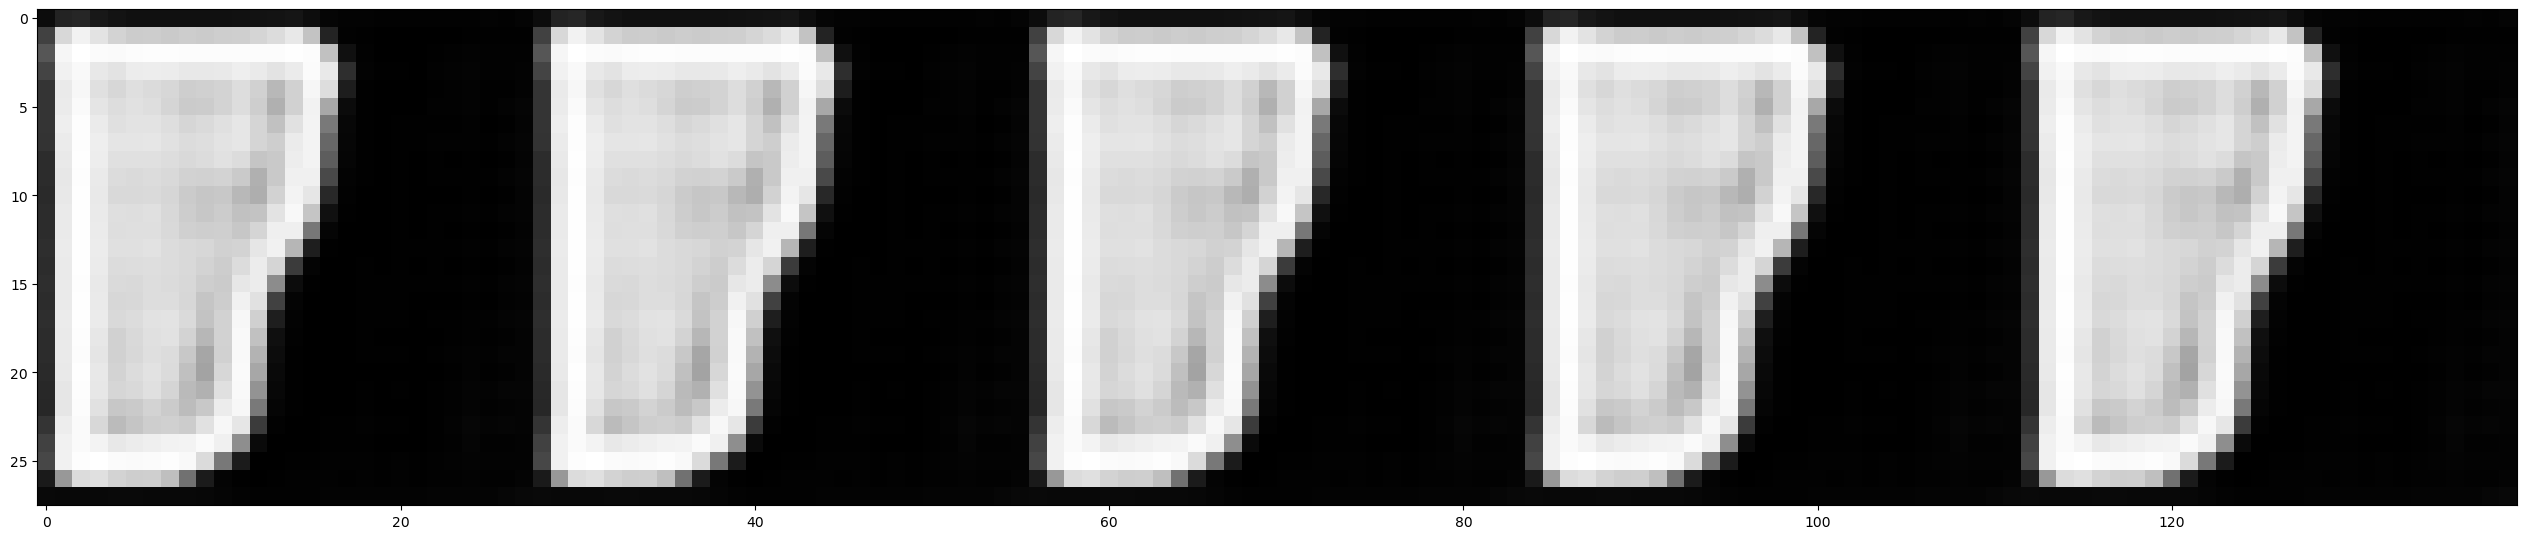

 37%|███████████████████████████                                              | 37/100 [44:33:34<83:02:04, 4744.84s/it]

Epoch [37/100] | Train Loss: 0.0974 | Validation Loss: 0.0931


 38%|███████████████████████████▋                                             | 38/100 [45:21:33<72:04:21, 4184.86s/it]

Epoch [38/100] | Train Loss: 0.0962 | Validation Loss: 0.0969


 39%|████████████████████████████▍                                            | 39/100 [46:09:47<64:21:01, 3797.72s/it]

Epoch [39/100] | Train Loss: 0.0946 | Validation Loss: 0.0911



 45%|████████████████████████████████████                                            | 135/300 [00:07<00:09, 18.24it/s]


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [00:14<00:01, 18.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.68it/s]


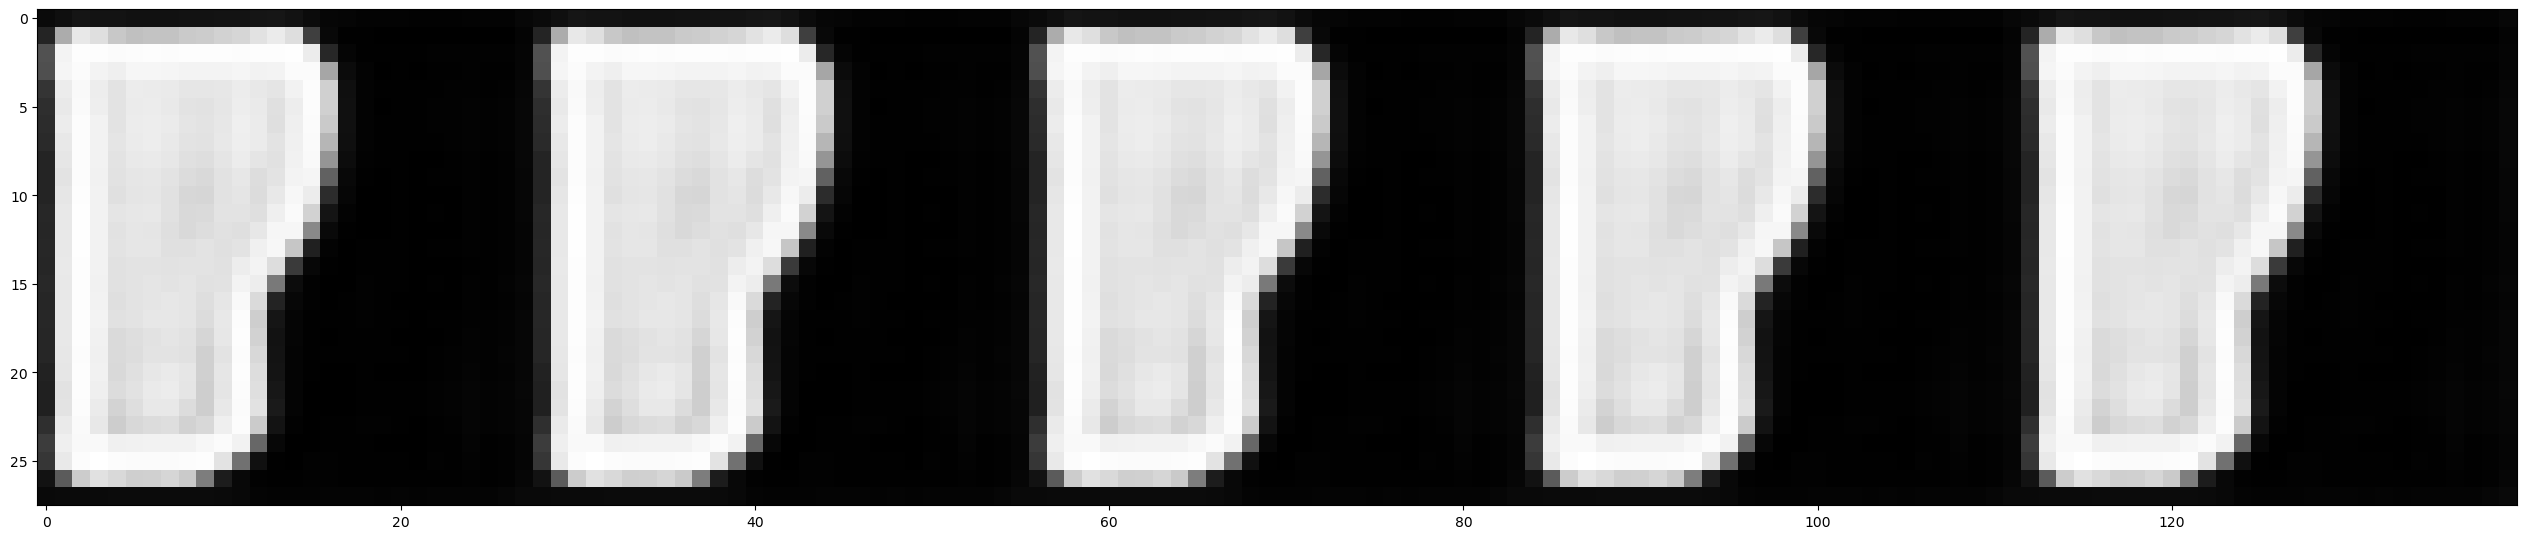

 40%|█████████████████████████████▏                                           | 40/100 [46:58:14<58:50:20, 3530.35s/it]

Epoch [40/100] | Train Loss: 0.0942 | Validation Loss: 0.0945


 41%|█████████████████████████████▉                                           | 41/100 [47:47:30<55:02:08, 3358.11s/it]

Epoch [41/100] | Train Loss: 0.0925 | Validation Loss: 0.0909


 42%|██████████████████████████████▋                                          | 42/100 [48:36:54<52:11:48, 3239.80s/it]

Epoch [42/100] | Train Loss: 0.0911 | Validation Loss: 0.0908



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.82it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.31it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.80it/s]


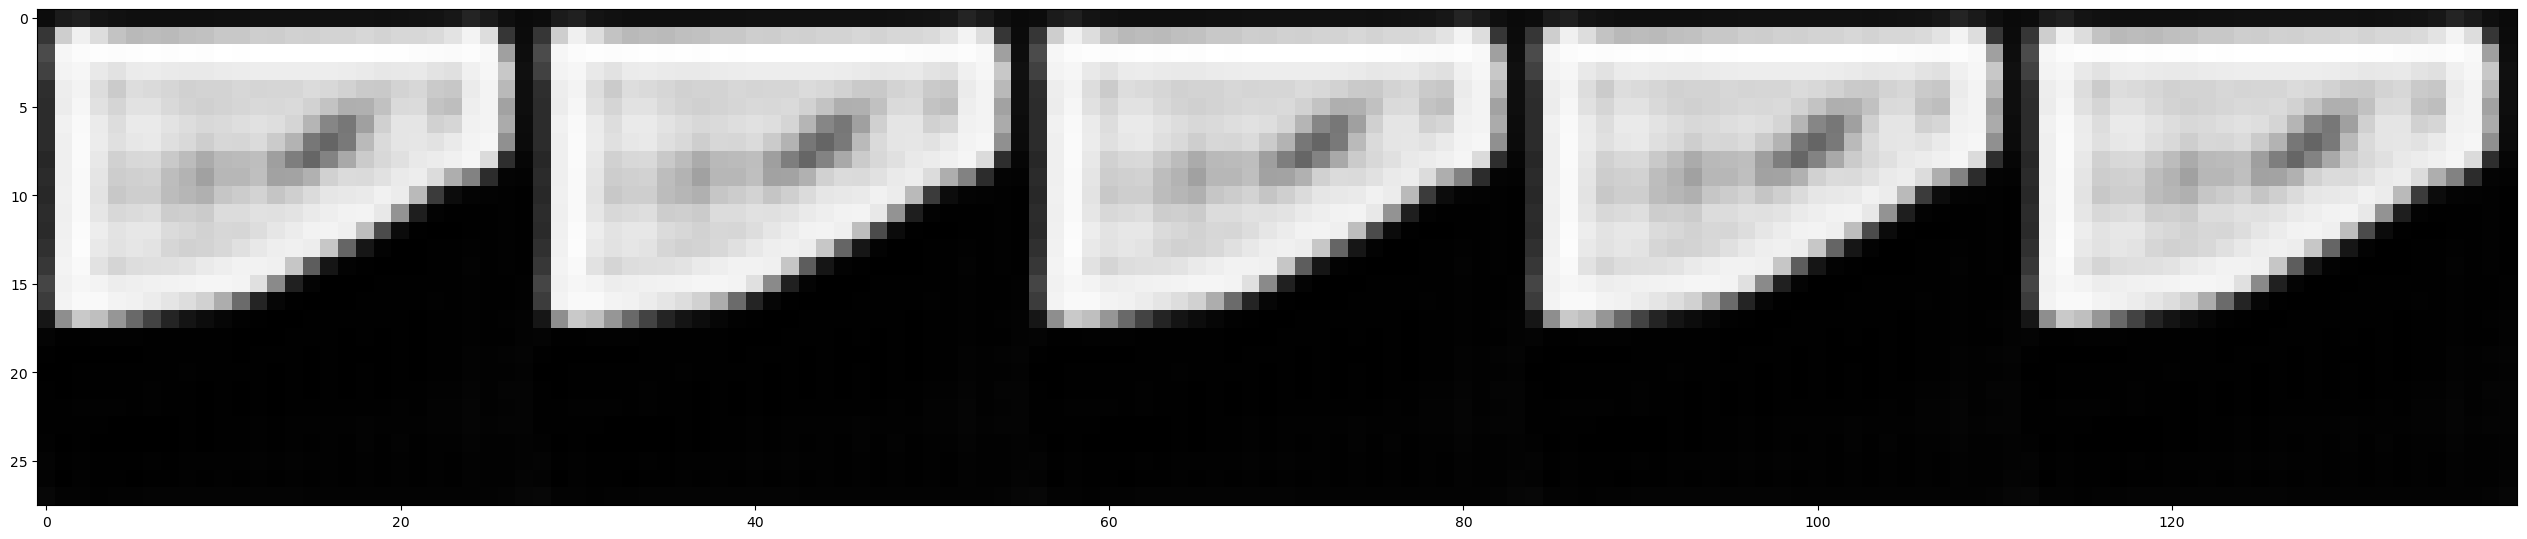

 43%|███████████████████████████████▍                                         | 43/100 [49:26:19<49:59:45, 3157.64s/it]

Epoch [43/100] | Train Loss: 0.0905 | Validation Loss: 0.0871


 44%|████████████████████████████████                                         | 44/100 [50:13:14<47:30:57, 3054.61s/it]

Epoch [44/100] | Train Loss: 0.0894 | Validation Loss: 0.0925


 45%|████████████████████████████████▊                                        | 45/100 [51:00:00<45:31:40, 2980.01s/it]

Epoch [45/100] | Train Loss: 0.0884 | Validation Loss: 0.0837



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.03it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 18.40it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.04it/s]


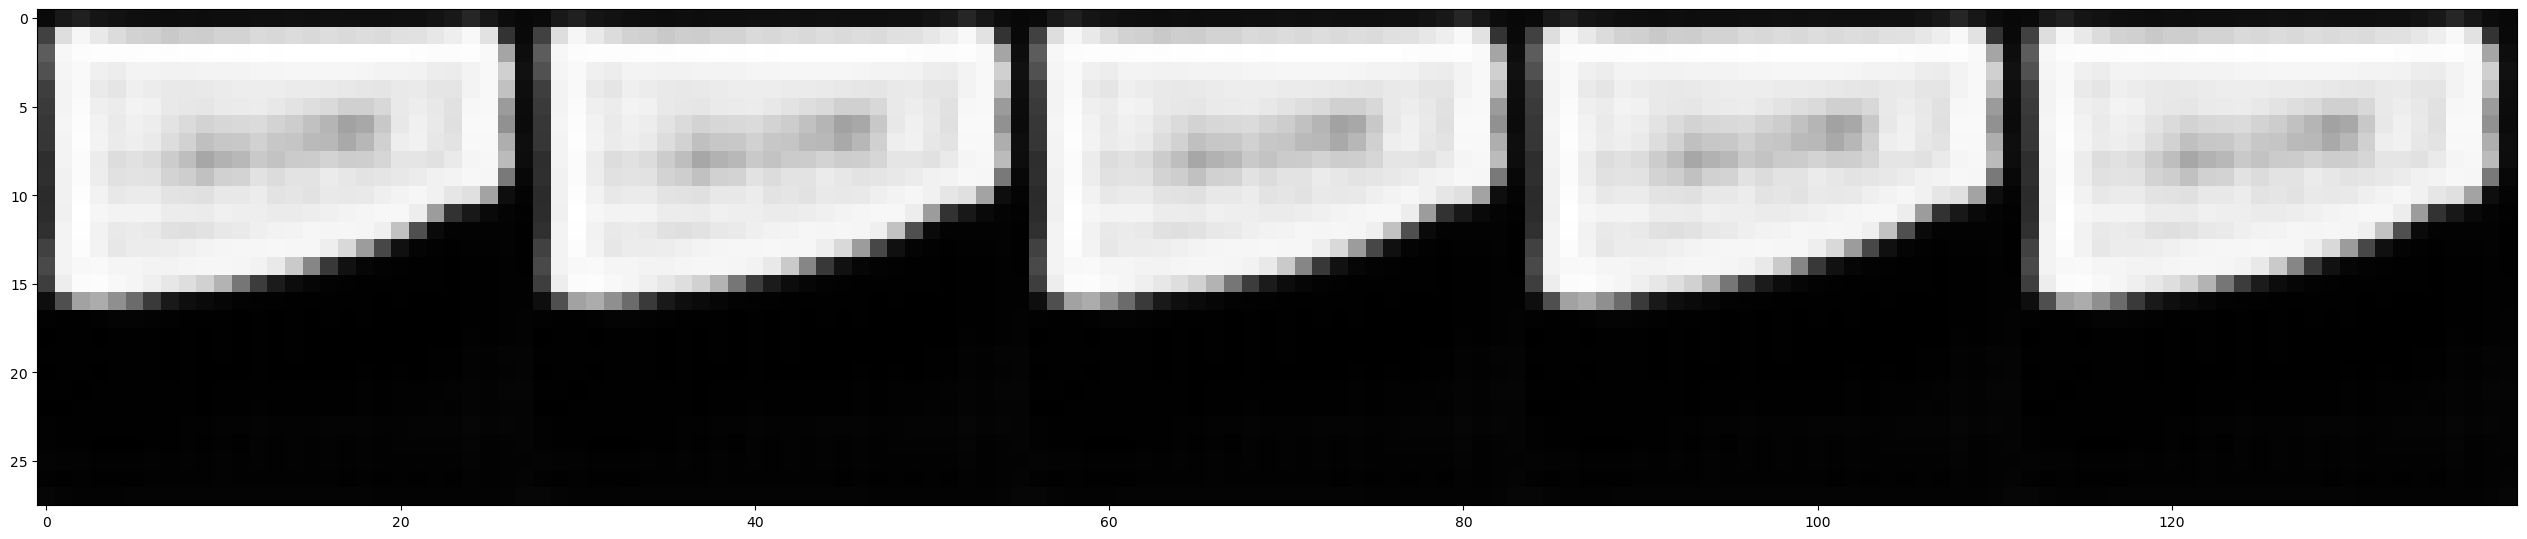

 46%|█████████████████████████████████▌                                       | 46/100 [51:48:50<44:28:35, 2965.11s/it]

Epoch [46/100] | Train Loss: 0.0869 | Validation Loss: 0.0861


 47%|██████████████████████████████████▎                                      | 47/100 [52:37:21<43:24:56, 2948.99s/it]

Epoch [47/100] | Train Loss: 0.0849 | Validation Loss: 0.0887


 48%|███████████████████████████████████                                      | 48/100 [53:25:42<42:23:17, 2934.57s/it]

Epoch [48/100] | Train Loss: 0.0845 | Validation Loss: 0.0854



 43%|██████████████████████████████████▋                                             | 130/300 [00:06<00:09, 18.72it/s]


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [00:14<00:01, 18.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.61it/s]


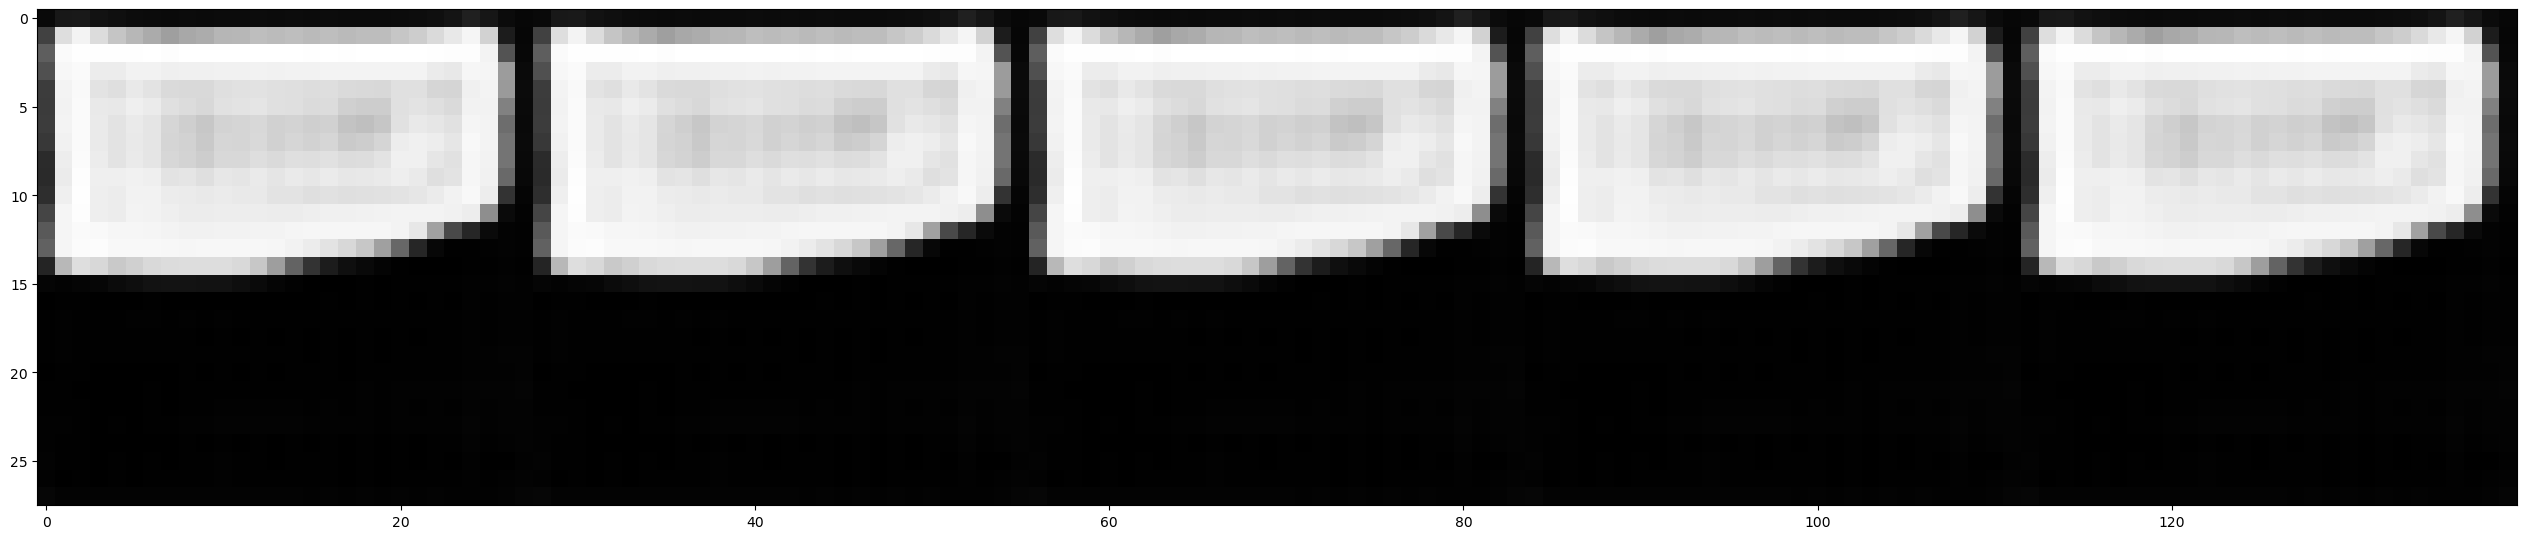

 49%|███████████████████████████████████▊                                     | 49/100 [54:14:20<41:30:09, 2929.60s/it]

Epoch [49/100] | Train Loss: 0.0834 | Validation Loss: 0.0850


 50%|████████████████████████████████████▌                                    | 50/100 [55:07:24<41:44:57, 3005.96s/it]

Epoch [50/100] | Train Loss: 0.0821 | Validation Loss: 0.0796


 51%|█████████████████████████████████████▏                                   | 51/100 [56:00:27<41:38:10, 3058.99s/it]

Epoch [51/100] | Train Loss: 0.0817 | Validation Loss: 0.0810



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:10, 16.79it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.53it/s]


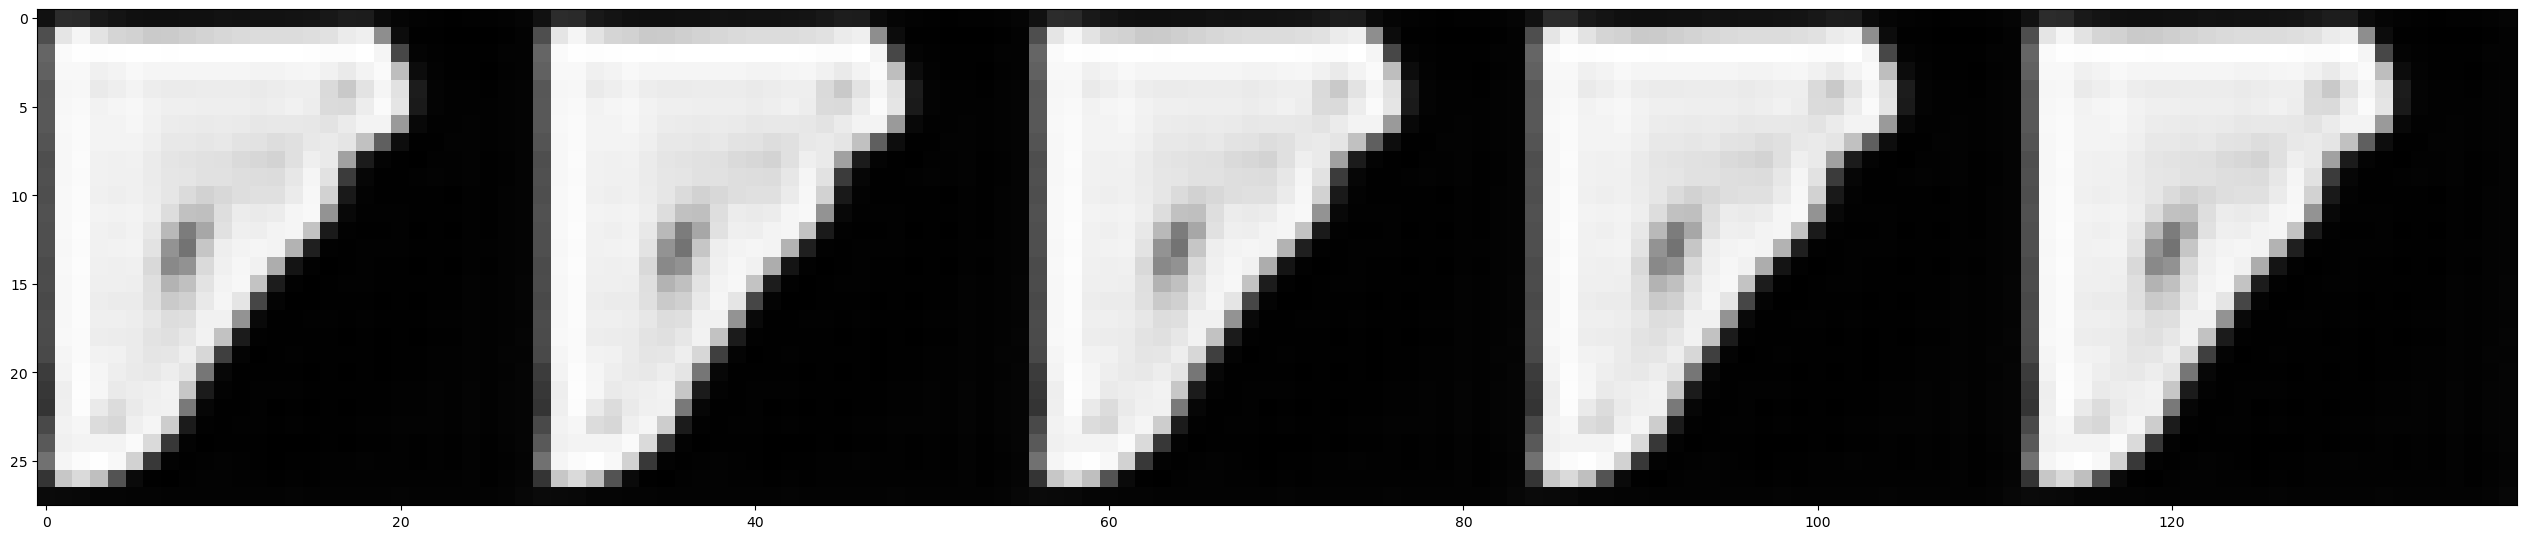

 52%|█████████████████████████████████████▉                                   | 52/100 [56:53:54<41:22:36, 3103.26s/it]

Epoch [52/100] | Train Loss: 0.0804 | Validation Loss: 0.0763


 53%|██████████████████████████████████████▋                                  | 53/100 [57:41:55<39:38:44, 3036.69s/it]

Epoch [53/100] | Train Loss: 0.0787 | Validation Loss: 0.0770


 54%|███████████████████████████████████████▍                                 | 54/100 [58:29:57<38:12:30, 2990.24s/it]

Epoch [54/100] | Train Loss: 0.0783 | Validation Loss: 0.0743



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.43it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 18.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.17it/s]


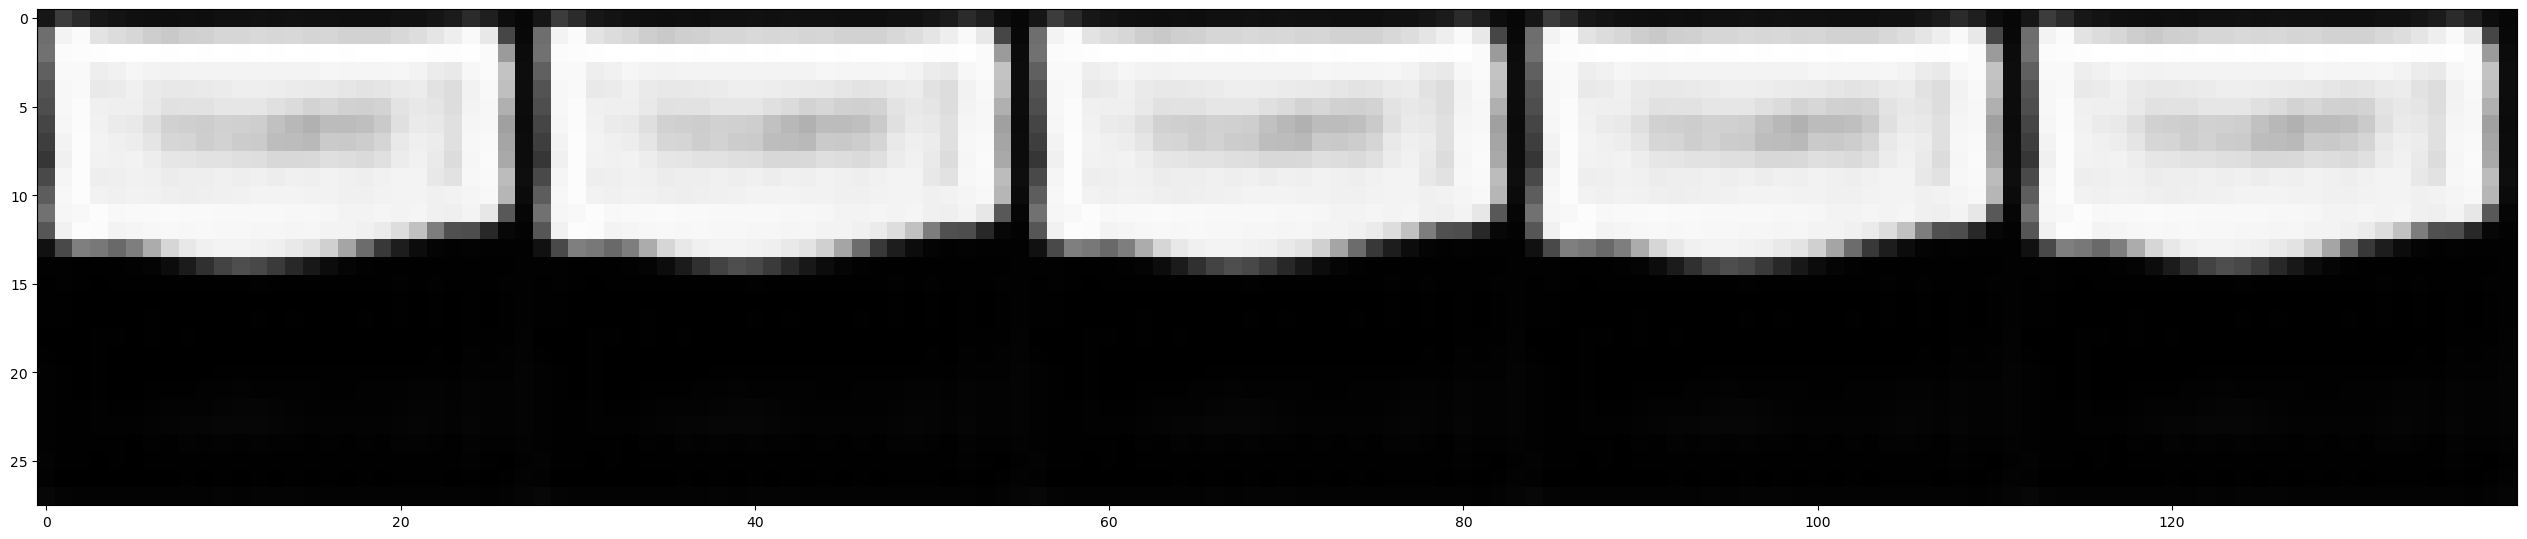

 55%|████████████████████████████████████████▏                                | 55/100 [59:18:14<37:01:44, 2962.32s/it]

Epoch [55/100] | Train Loss: 0.0772 | Validation Loss: 0.0764


 56%|████████████████████████████████████████▉                                | 56/100 [60:07:19<36:08:36, 2957.20s/it]

Epoch [56/100] | Train Loss: 0.0756 | Validation Loss: 0.0746


 57%|█████████████████████████████████████████▌                               | 57/100 [60:59:56<36:02:18, 3017.17s/it]

Epoch [57/100] | Train Loss: 0.0751 | Validation Loss: 0.0755



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.28it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:14<00:02, 17.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.14it/s]


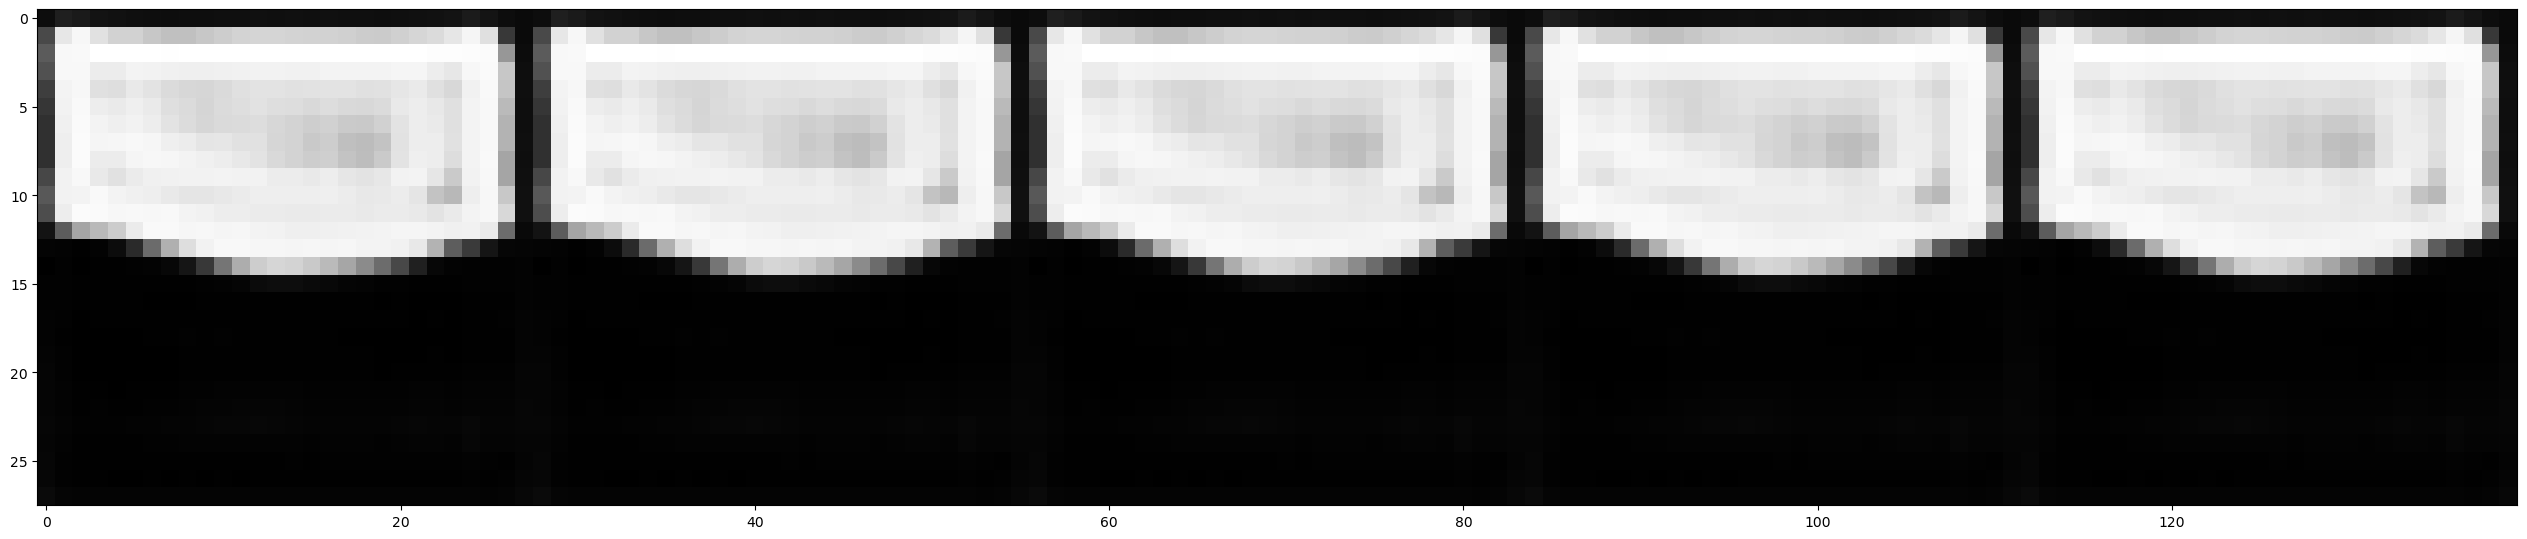

 58%|██████████████████████████████████████████▎                              | 58/100 [61:47:54<34:42:44, 2975.36s/it]

Epoch [58/100] | Train Loss: 0.0745 | Validation Loss: 0.0787


 59%|███████████████████████████████████████████                              | 59/100 [62:36:00<33:34:44, 2948.40s/it]

Epoch [59/100] | Train Loss: 0.0734 | Validation Loss: 0.0719


 60%|███████████████████████████████████████████▊                             | 60/100 [63:24:17<32:35:16, 2932.92s/it]

Epoch [60/100] | Train Loss: 0.0725 | Validation Loss: 0.0696



 44%|███████████████████████████████████▍                                            | 133/300 [00:07<00:08, 18.94it/s]


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [00:14<00:01, 18.58it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 18.79it/s]


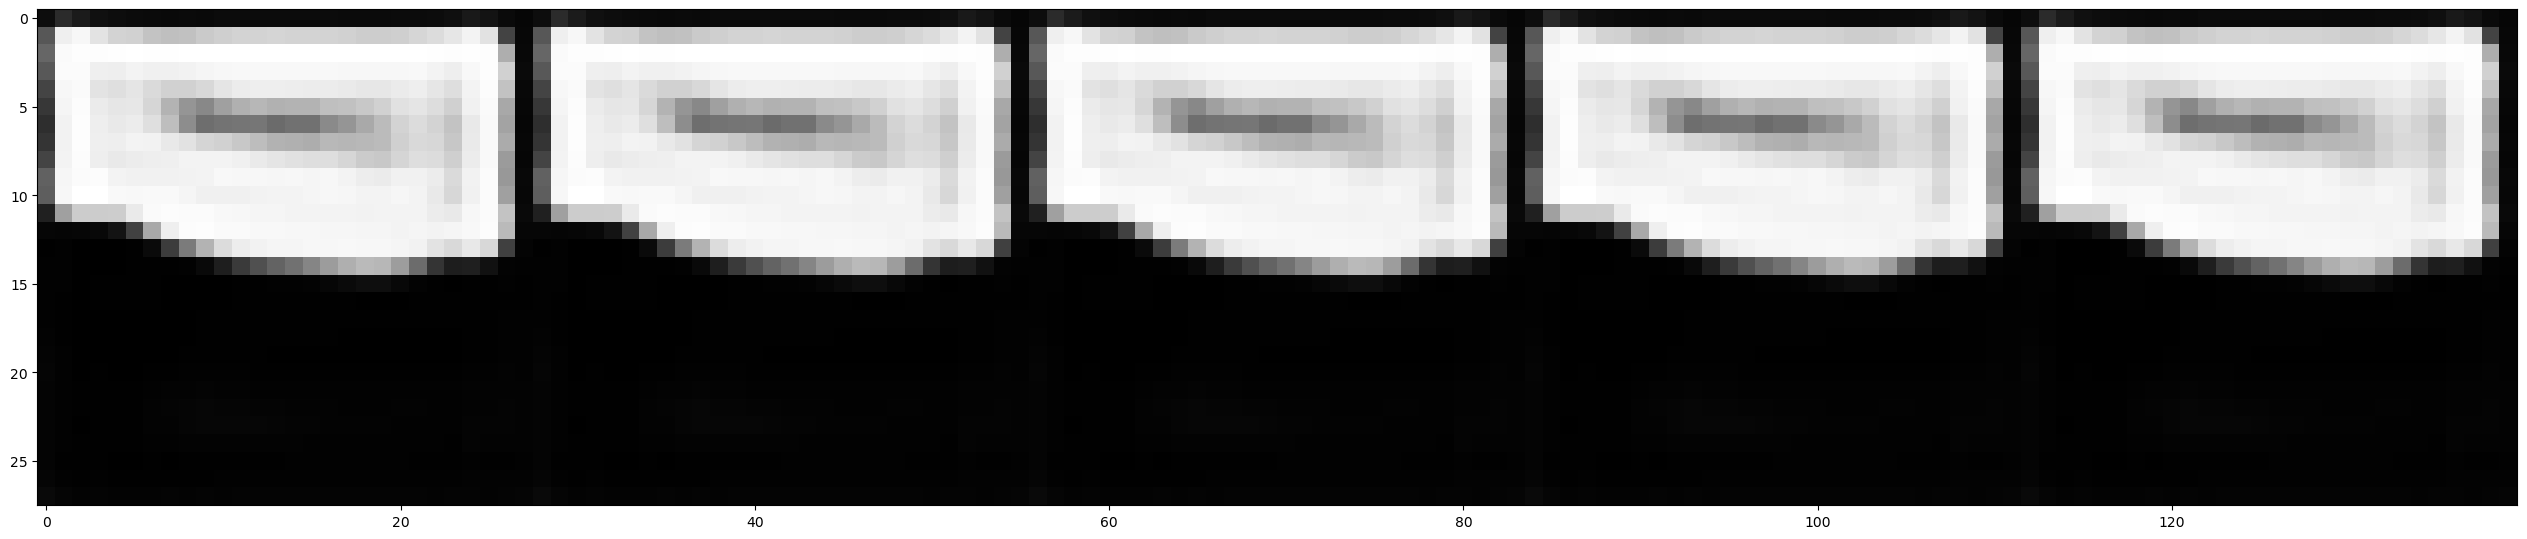

 61%|████████████████████████████████████████████▌                            | 61/100 [64:12:42<31:41:02, 2924.67s/it]

Epoch [61/100] | Train Loss: 0.0710 | Validation Loss: 0.0687


 62%|█████████████████████████████████████████████▎                           | 62/100 [65:00:48<30:44:57, 2913.09s/it]

Epoch [62/100] | Train Loss: 0.0742 | Validation Loss: 0.0686


 63%|█████████████████████████████████████████████▉                           | 63/100 [65:48:55<29:51:37, 2905.34s/it]

Epoch [63/100] | Train Loss: 0.0708 | Validation Loss: 0.0686



 44%|██████████████████████████████████▉                                             | 131/300 [00:07<00:09, 17.81it/s]


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [00:14<00:01, 18.65it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.45it/s]


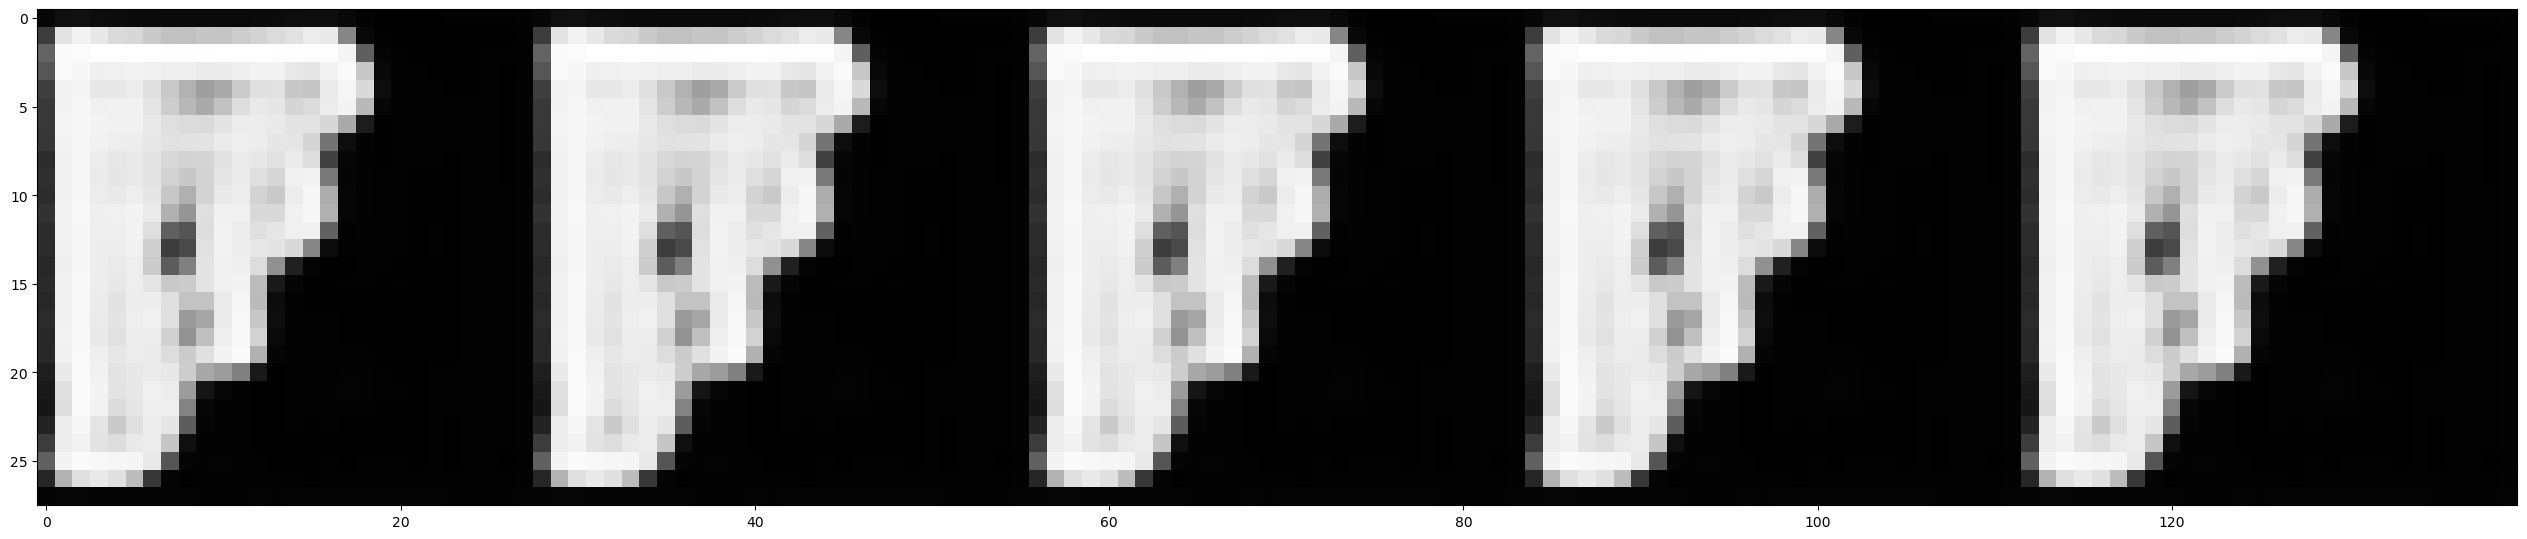

 64%|██████████████████████████████████████████████▋                          | 64/100 [66:37:19<29:02:59, 2904.98s/it]

Epoch [64/100] | Train Loss: 0.0684 | Validation Loss: 0.0663


 65%|███████████████████████████████████████████████▍                         | 65/100 [67:28:30<28:43:31, 2954.61s/it]

Epoch [65/100] | Train Loss: 0.0679 | Validation Loss: 0.0658


 66%|████████████████████████████████████████████████▏                        | 66/100 [68:17:24<27:50:44, 2948.37s/it]

Epoch [66/100] | Train Loss: 0.0684 | Validation Loss: 0.0649



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.88it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:15<00:02, 17.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.36it/s]


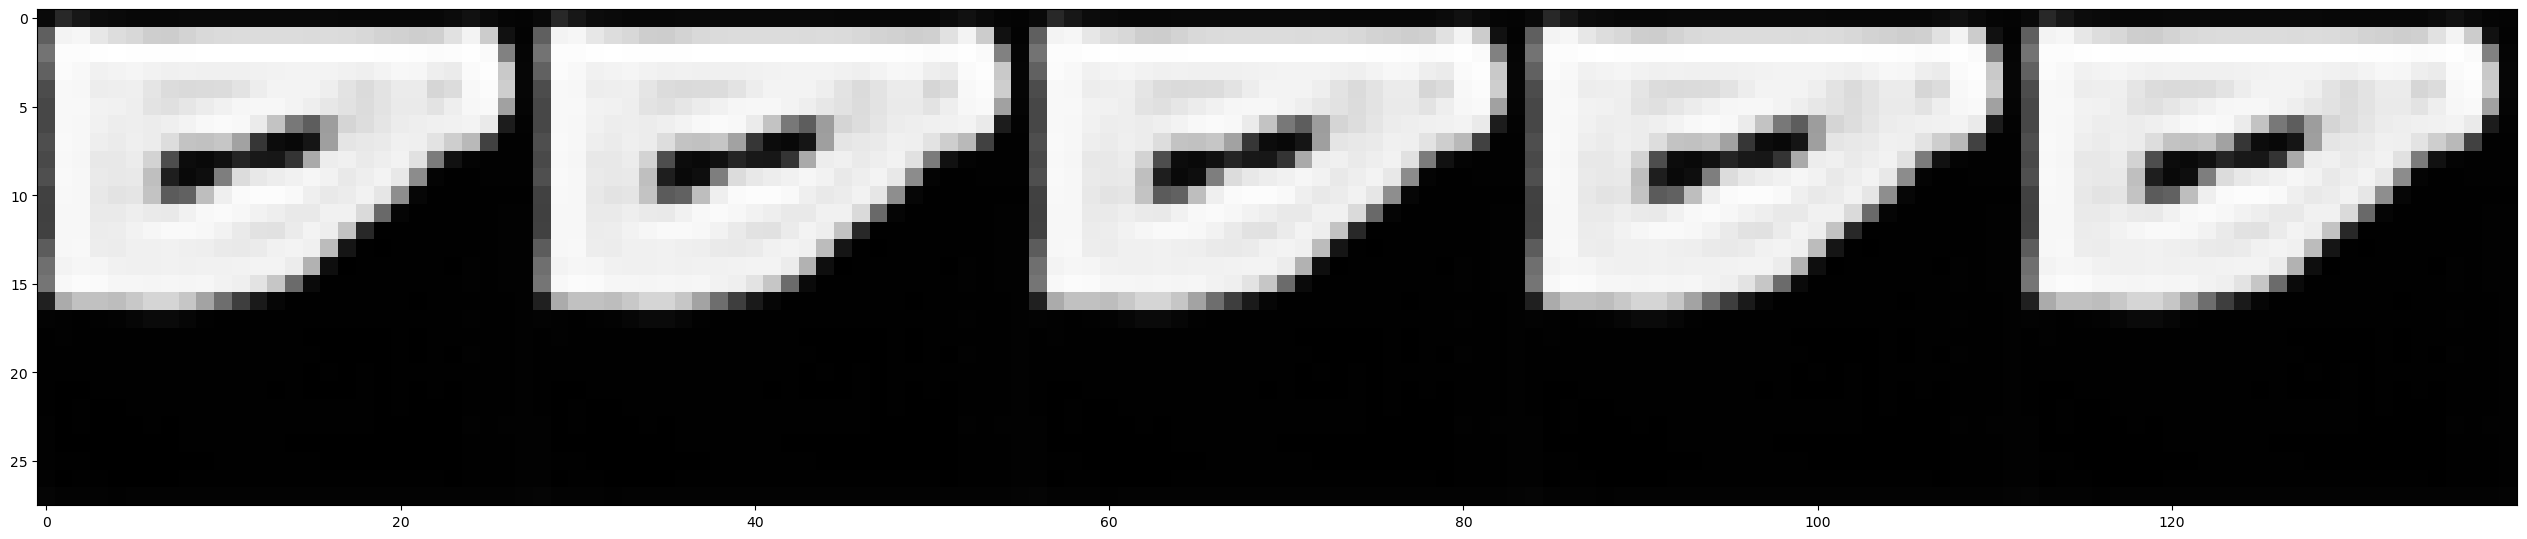

 67%|████████████████████████████████████████████████▉                        | 67/100 [69:05:26<26:50:42, 2928.56s/it]

Epoch [67/100] | Train Loss: 0.0669 | Validation Loss: 0.0675


 68%|█████████████████████████████████████████████████▋                       | 68/100 [69:53:43<25:56:53, 2919.17s/it]

Epoch [68/100] | Train Loss: 0.0651 | Validation Loss: 0.0626


 69%|██████████████████████████████████████████████████▎                      | 69/100 [70:42:00<25:04:49, 2912.56s/it]

Epoch [69/100] | Train Loss: 0.0652 | Validation Loss: 0.0658



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.18it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.90it/s]


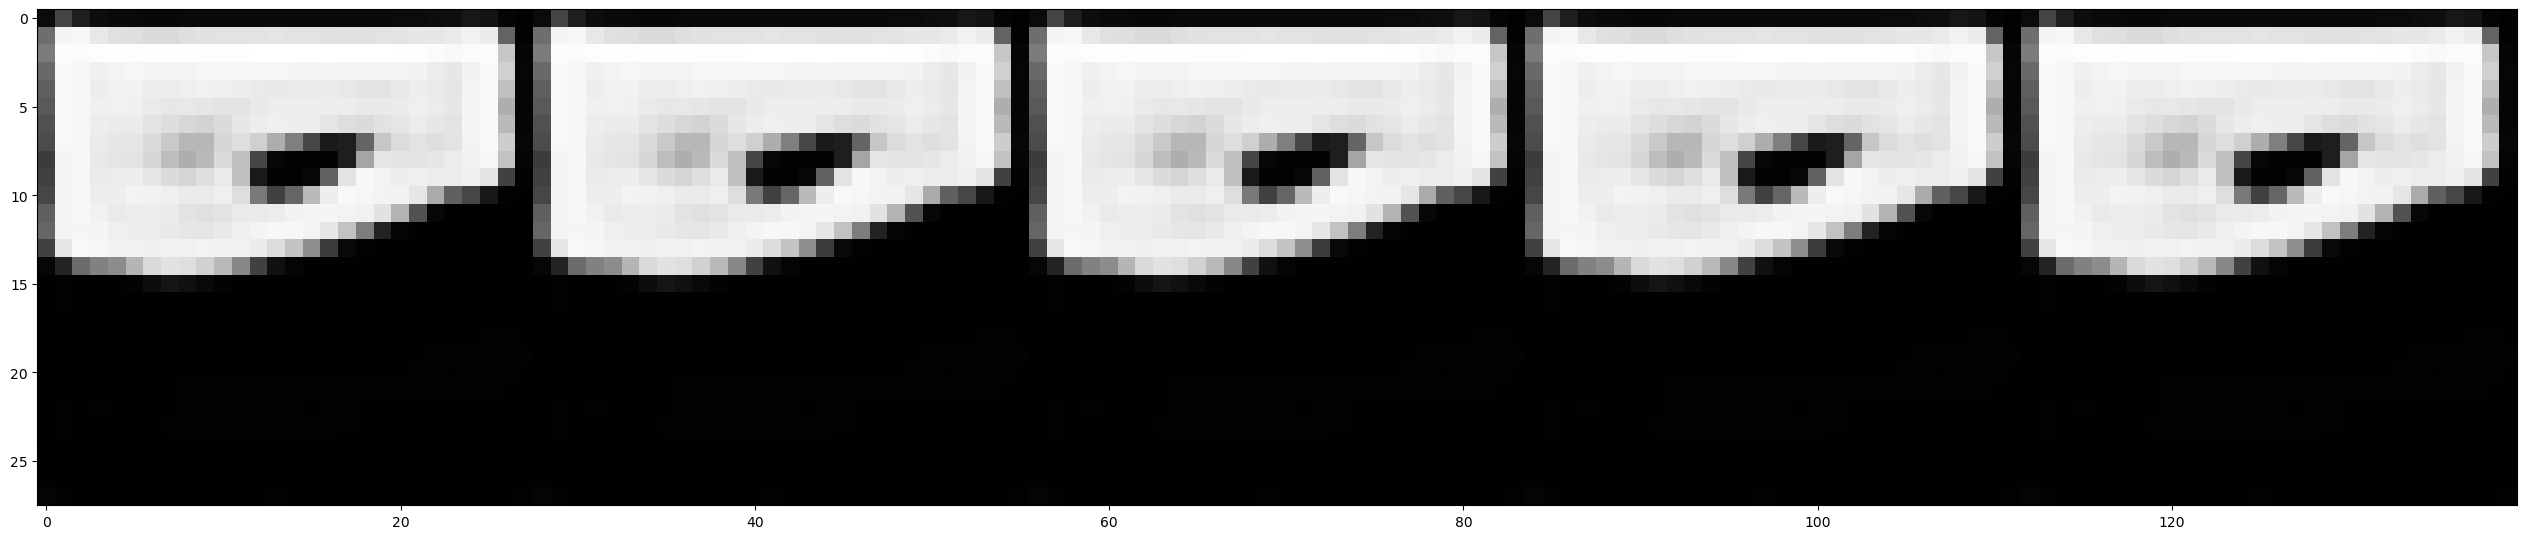

 70%|███████████████████████████████████████████████████                      | 70/100 [71:33:09<24:39:41, 2959.38s/it]

Epoch [70/100] | Train Loss: 0.0642 | Validation Loss: 0.0652


 71%|███████████████████████████████████████████████████▊                     | 71/100 [72:23:06<23:55:51, 2970.75s/it]

Epoch [71/100] | Train Loss: 0.0644 | Validation Loss: 0.0623


 72%|████████████████████████████████████████████████████▌                    | 72/100 [73:10:24<22:47:42, 2930.79s/it]

Epoch [72/100] | Train Loss: 0.0640 | Validation Loss: 0.0628



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 17.47it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.26it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.61it/s]


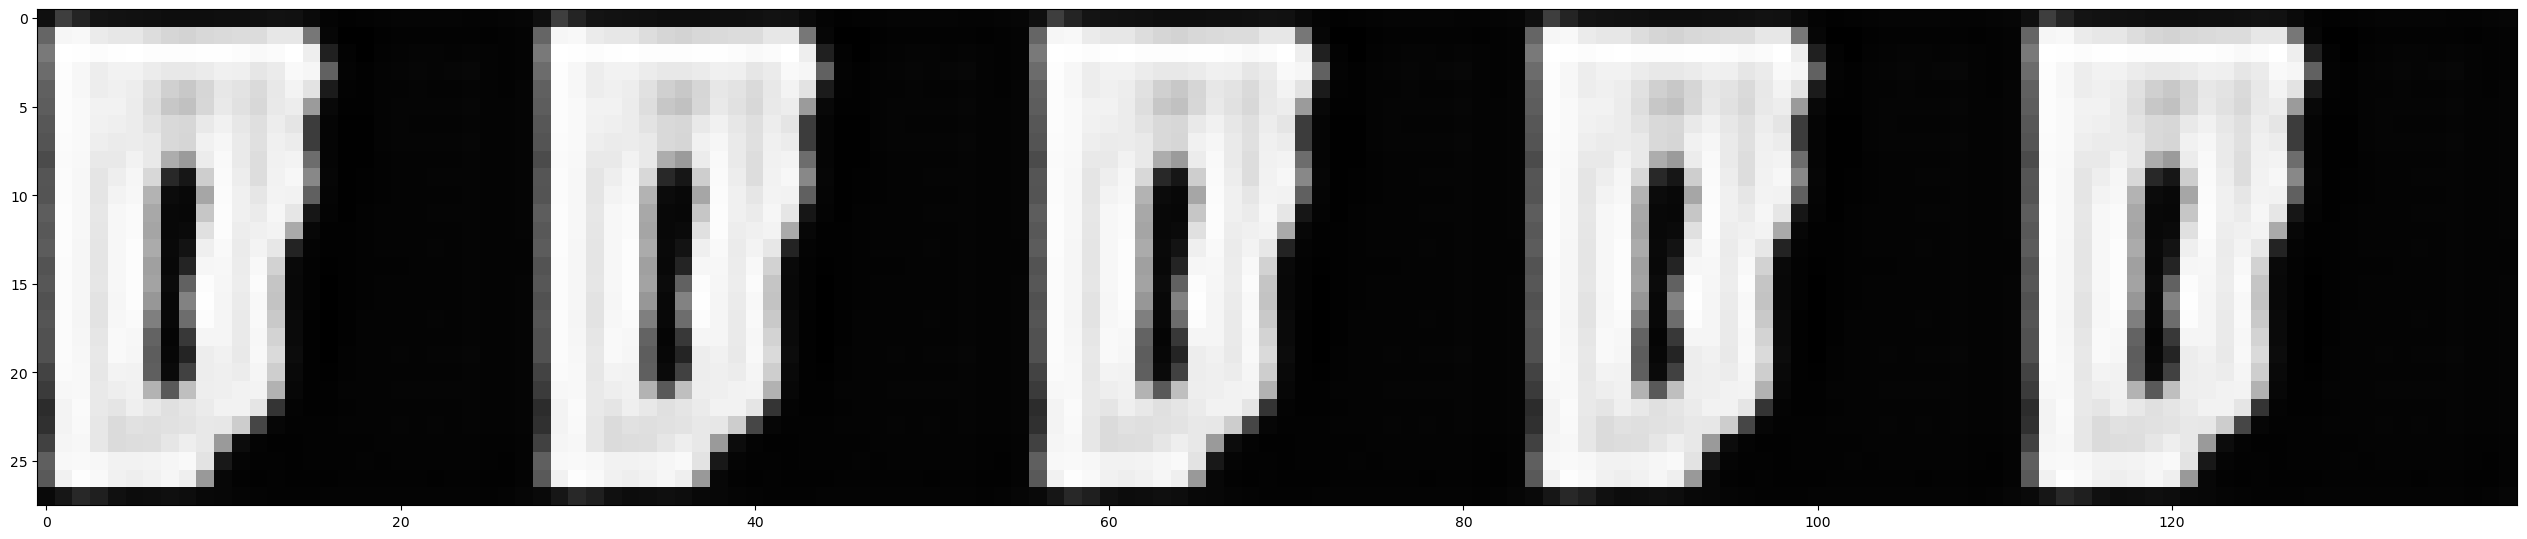

 73%|█████████████████████████████████████████████████████▎                   | 73/100 [73:57:57<21:48:22, 2907.51s/it]

Epoch [73/100] | Train Loss: 0.0635 | Validation Loss: 0.0639


 74%|██████████████████████████████████████████████████████                   | 74/100 [74:49:40<21:25:17, 2966.08s/it]

Epoch [74/100] | Train Loss: 0.0637 | Validation Loss: 0.0625


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [75:41:17<20:52:18, 3005.54s/it]

Epoch [75/100] | Train Loss: 0.0612 | Validation Loss: 0.0605



 44%|██████████████████████████████████▉                                             | 131/300 [00:07<00:09, 18.46it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:14<00:01, 18.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.45it/s]


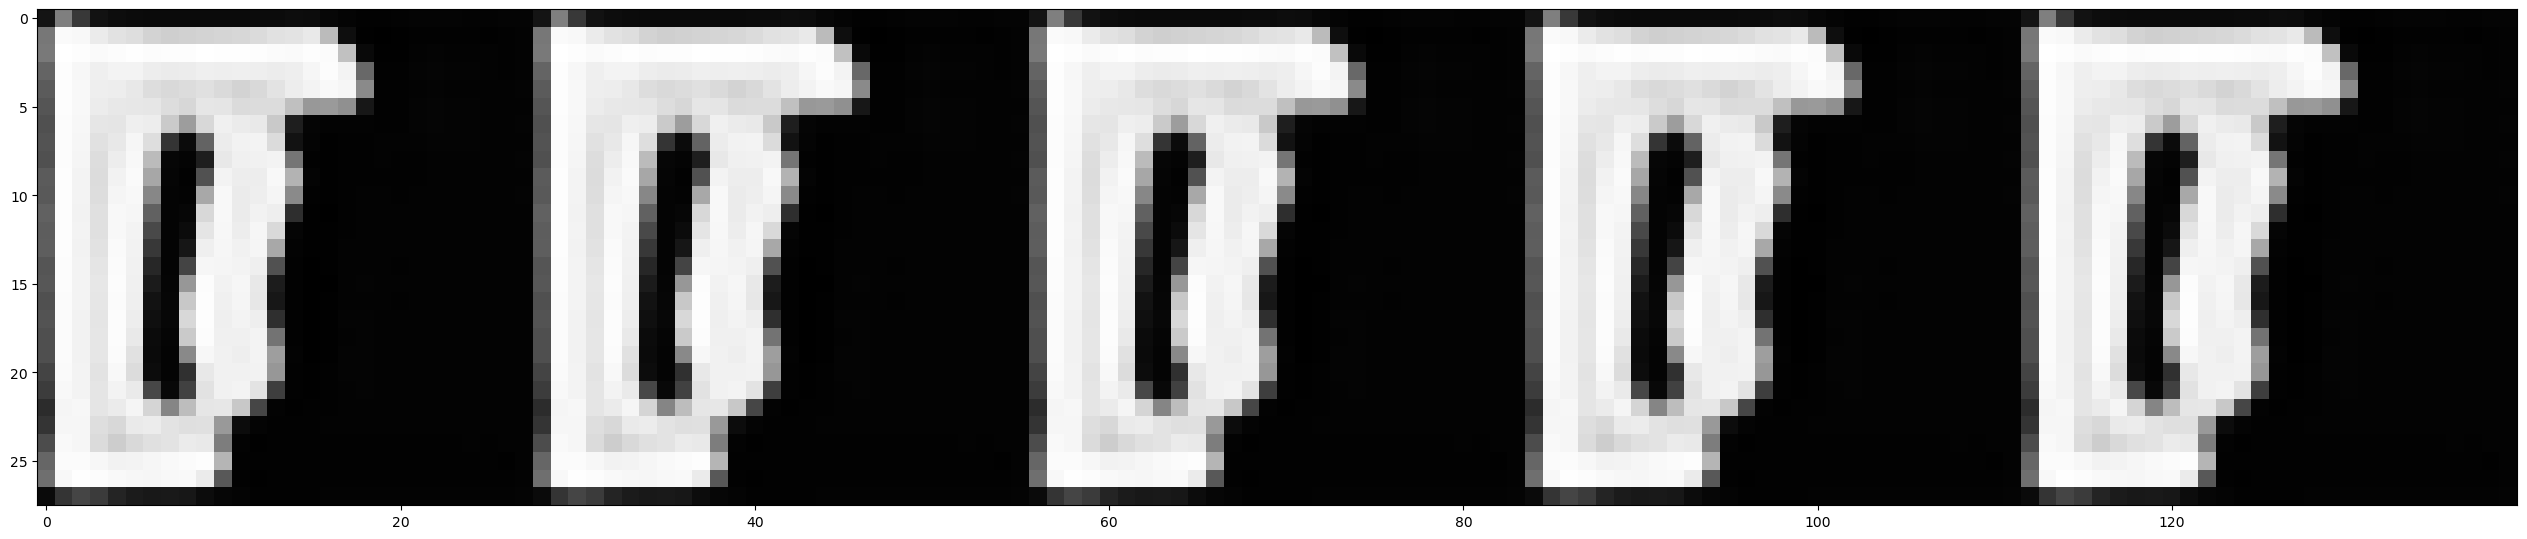

 76%|███████████████████████████████████████████████████████▍                 | 76/100 [76:33:21<20:16:20, 3040.87s/it]

Epoch [76/100] | Train Loss: 0.0600 | Validation Loss: 0.0593


 77%|████████████████████████████████████████████████████████▏                | 77/100 [77:25:11<19:33:37, 3061.61s/it]

Epoch [77/100] | Train Loss: 0.0601 | Validation Loss: 0.0594


 78%|████████████████████████████████████████████████████████▉                | 78/100 [78:17:02<18:48:02, 3076.49s/it]

Epoch [78/100] | Train Loss: 0.0606 | Validation Loss: 0.0573



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.78it/s]


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [00:14<00:01, 19.87it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.64it/s]


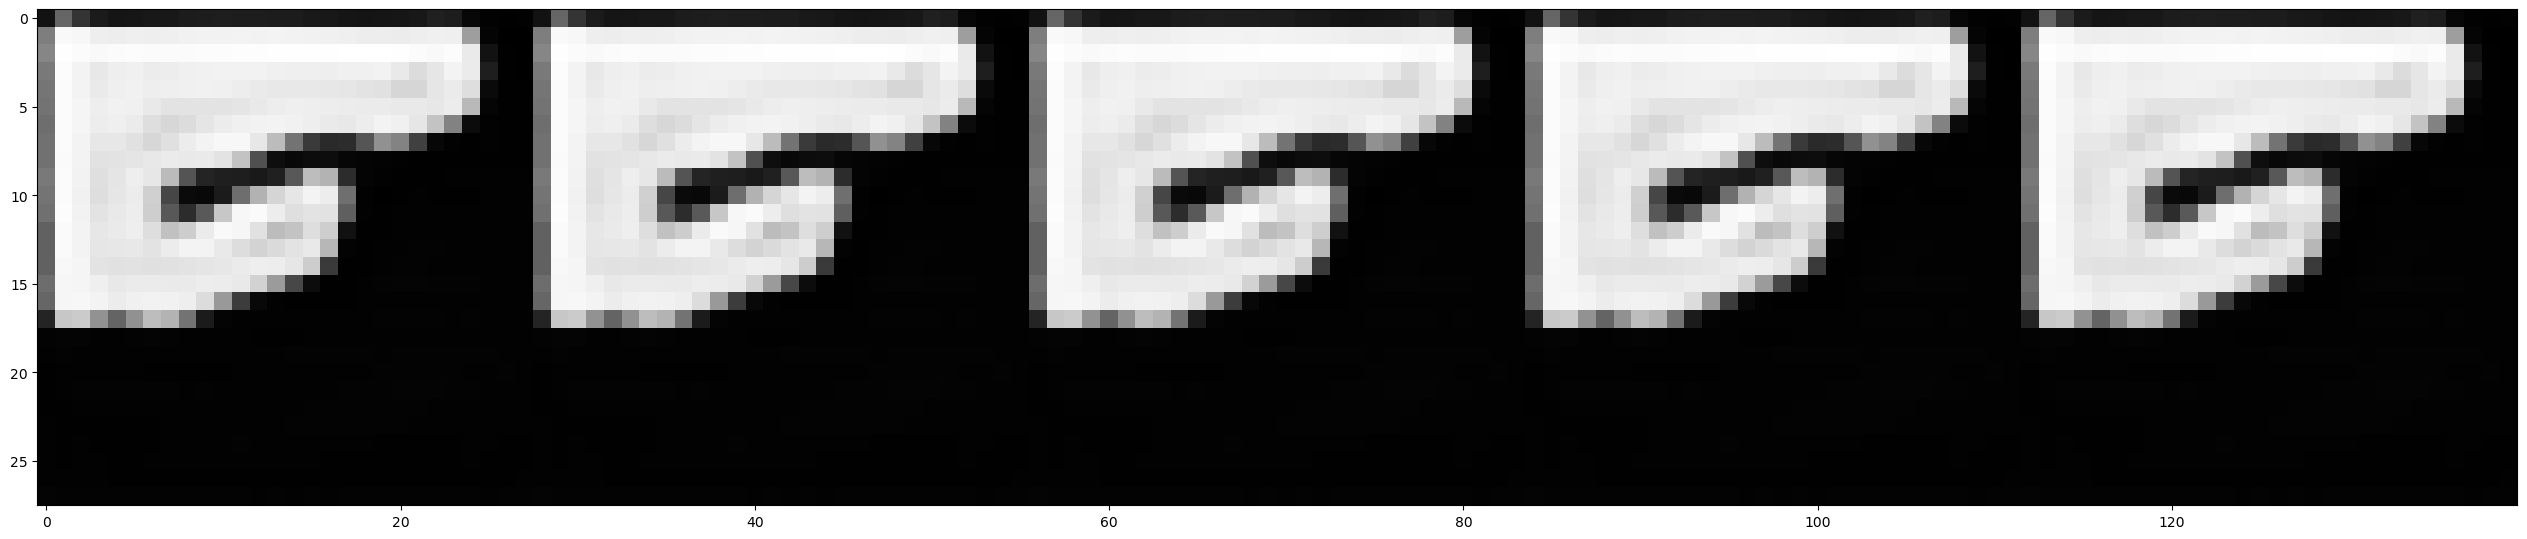

 79%|█████████████████████████████████████████████████████████▋               | 79/100 [79:09:09<18:02:07, 3091.77s/it]

Epoch [79/100] | Train Loss: 0.0588 | Validation Loss: 0.0587


 80%|██████████████████████████████████████████████████████████▍              | 80/100 [80:00:46<17:11:04, 3093.24s/it]

Epoch [80/100] | Train Loss: 0.0609 | Validation Loss: 0.0598


 81%|███████████████████████████████████████████████████████████▏             | 81/100 [80:52:23<16:19:53, 3094.41s/it]

Epoch [81/100] | Train Loss: 0.0572 | Validation Loss: 0.0553



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:09, 18.67it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:14<00:02, 17.14it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.73it/s]


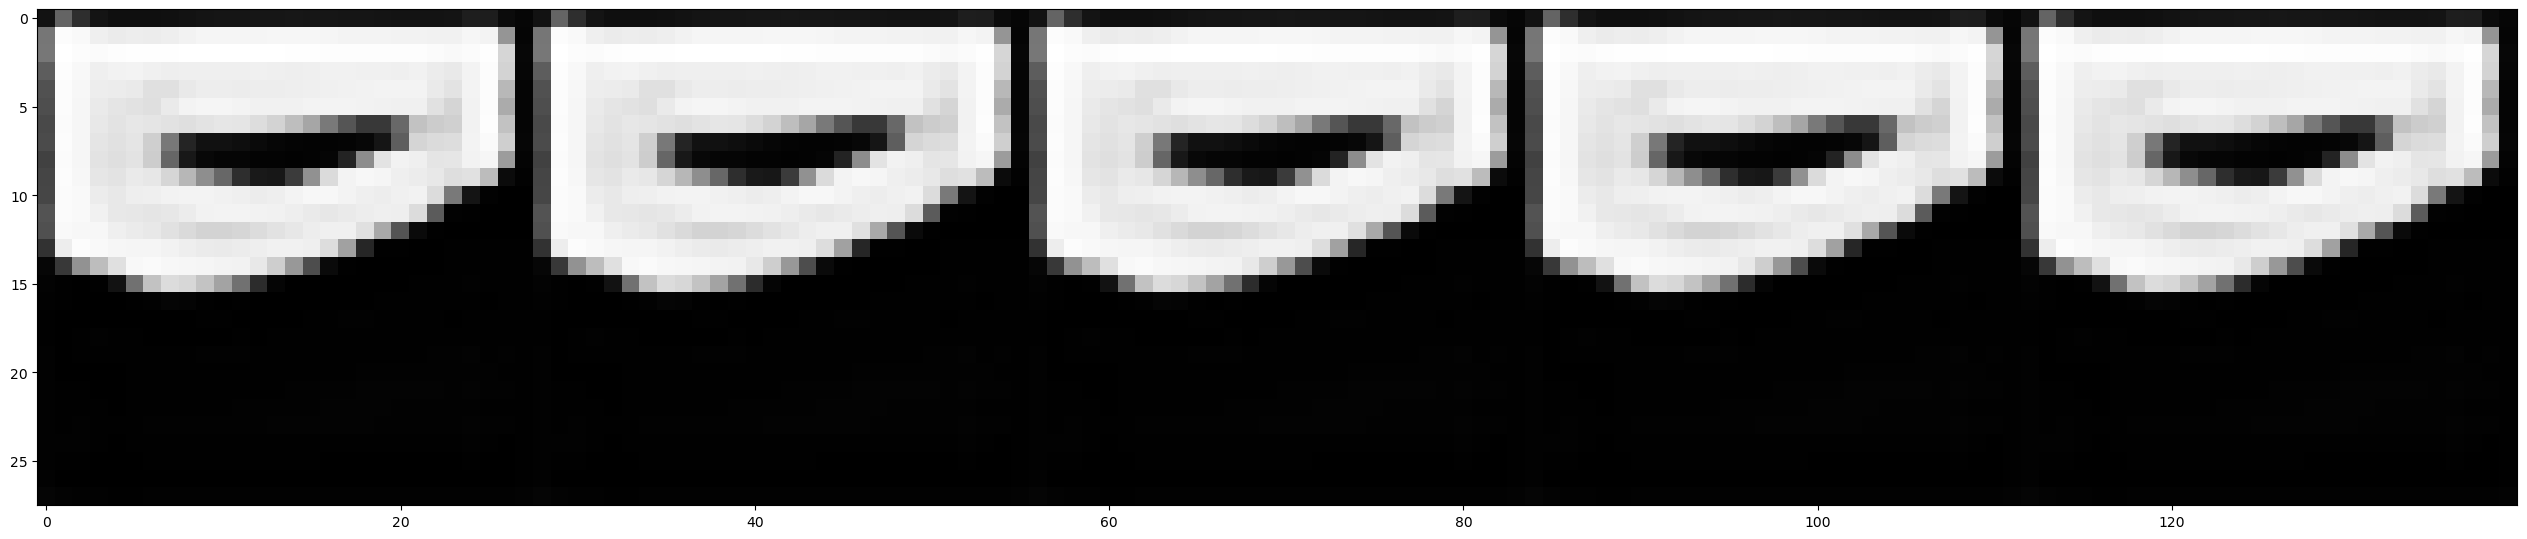

 82%|███████████████████████████████████████████████████████████▊             | 82/100 [81:44:17<15:30:03, 3100.17s/it]

Epoch [82/100] | Train Loss: 0.0572 | Validation Loss: 0.0549


 83%|████████████████████████████████████████████████████████████▌            | 83/100 [82:31:23<14:15:06, 3018.05s/it]

Epoch [83/100] | Train Loss: 0.0580 | Validation Loss: 0.0560


 84%|█████████████████████████████████████████████████████████████▎           | 84/100 [83:18:42<13:10:27, 2964.20s/it]

Epoch [84/100] | Train Loss: 0.0552 | Validation Loss: 0.0552



 43%|██████████████████████████████████▋                                             | 130/300 [00:07<00:10, 16.97it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:15<00:02, 16.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.03it/s]


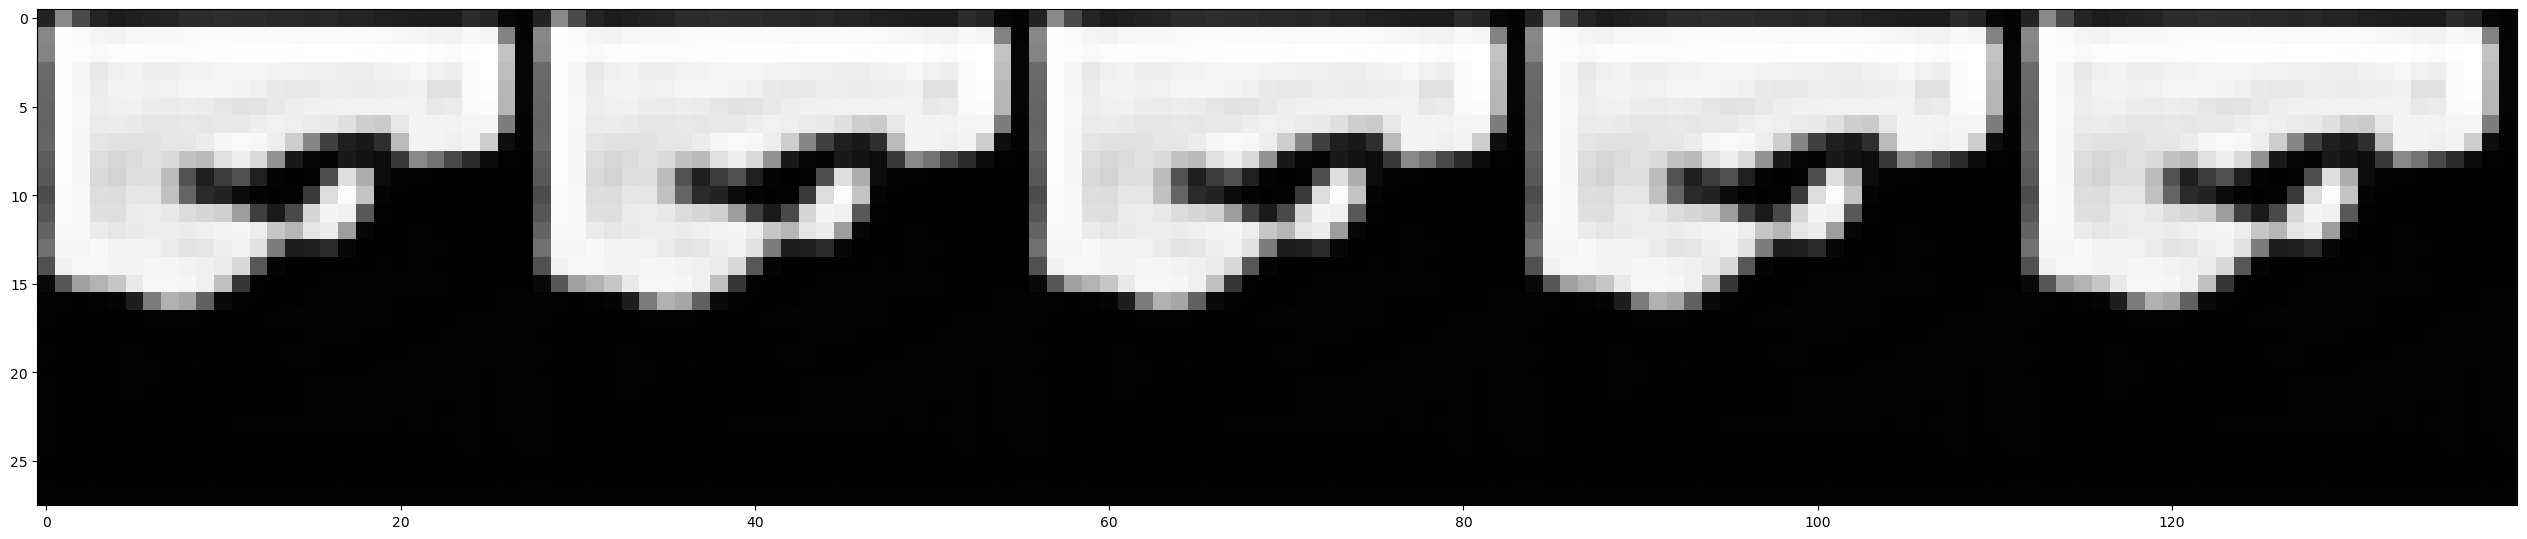

 85%|██████████████████████████████████████████████████████████████           | 85/100 [84:06:20<12:13:06, 2932.41s/it]

Epoch [85/100] | Train Loss: 0.0557 | Validation Loss: 0.0578


 86%|██████████████████████████████████████████████████████████████▊          | 86/100 [84:53:51<11:18:30, 2907.90s/it]

Epoch [86/100] | Train Loss: 0.0547 | Validation Loss: 0.0560


 87%|███████████████████████████████████████████████████████████████▌         | 87/100 [85:41:15<10:25:56, 2888.93s/it]

Epoch [87/100] | Train Loss: 0.0550 | Validation Loss: 0.0546



 44%|██████████████████████████████████▉                                             | 131/300 [00:07<00:09, 17.56it/s]


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:14<00:02, 18.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.75it/s]


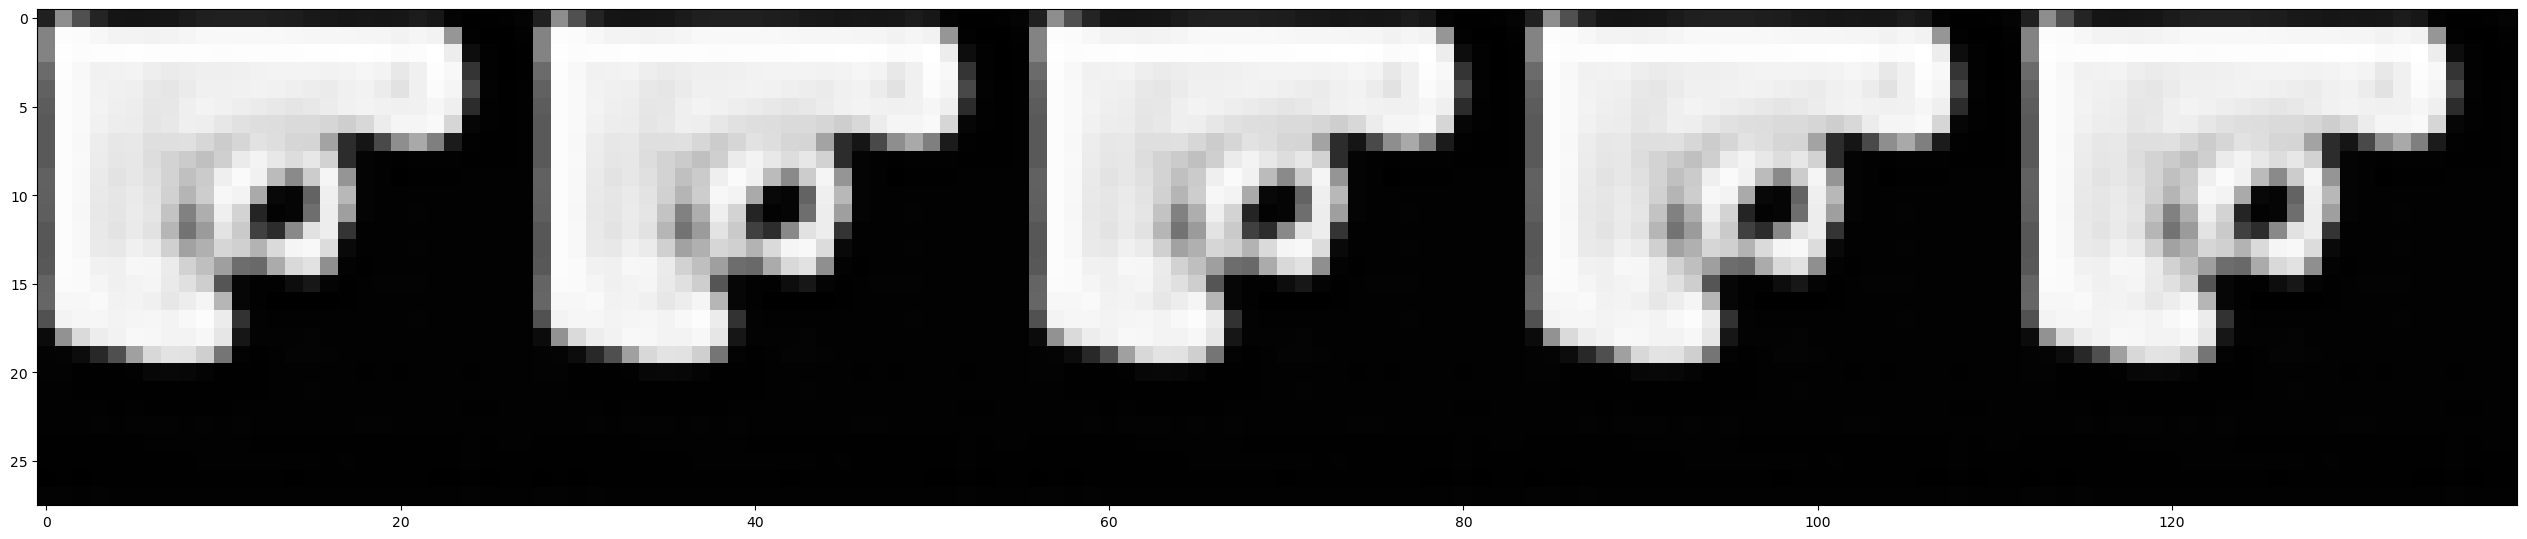

 88%|█████████████████████████████████████████████████████████████████         | 88/100 [86:28:46<9:35:27, 2877.31s/it]

Epoch [88/100] | Train Loss: 0.0550 | Validation Loss: 0.0536


 89%|█████████████████████████████████████████████████████████████████▊        | 89/100 [87:15:59<8:45:04, 2864.03s/it]

Epoch [89/100] | Train Loss: 0.0538 | Validation Loss: 0.0519


 90%|██████████████████████████████████████████████████████████████████▌       | 90/100 [88:03:54<7:57:53, 2867.33s/it]

Epoch [90/100] | Train Loss: 0.0543 | Validation Loss: 0.0543



 44%|███████████████████████████████████▏                                            | 132/300 [00:07<00:09, 18.47it/s]


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [00:14<00:01, 18.57it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.45it/s]


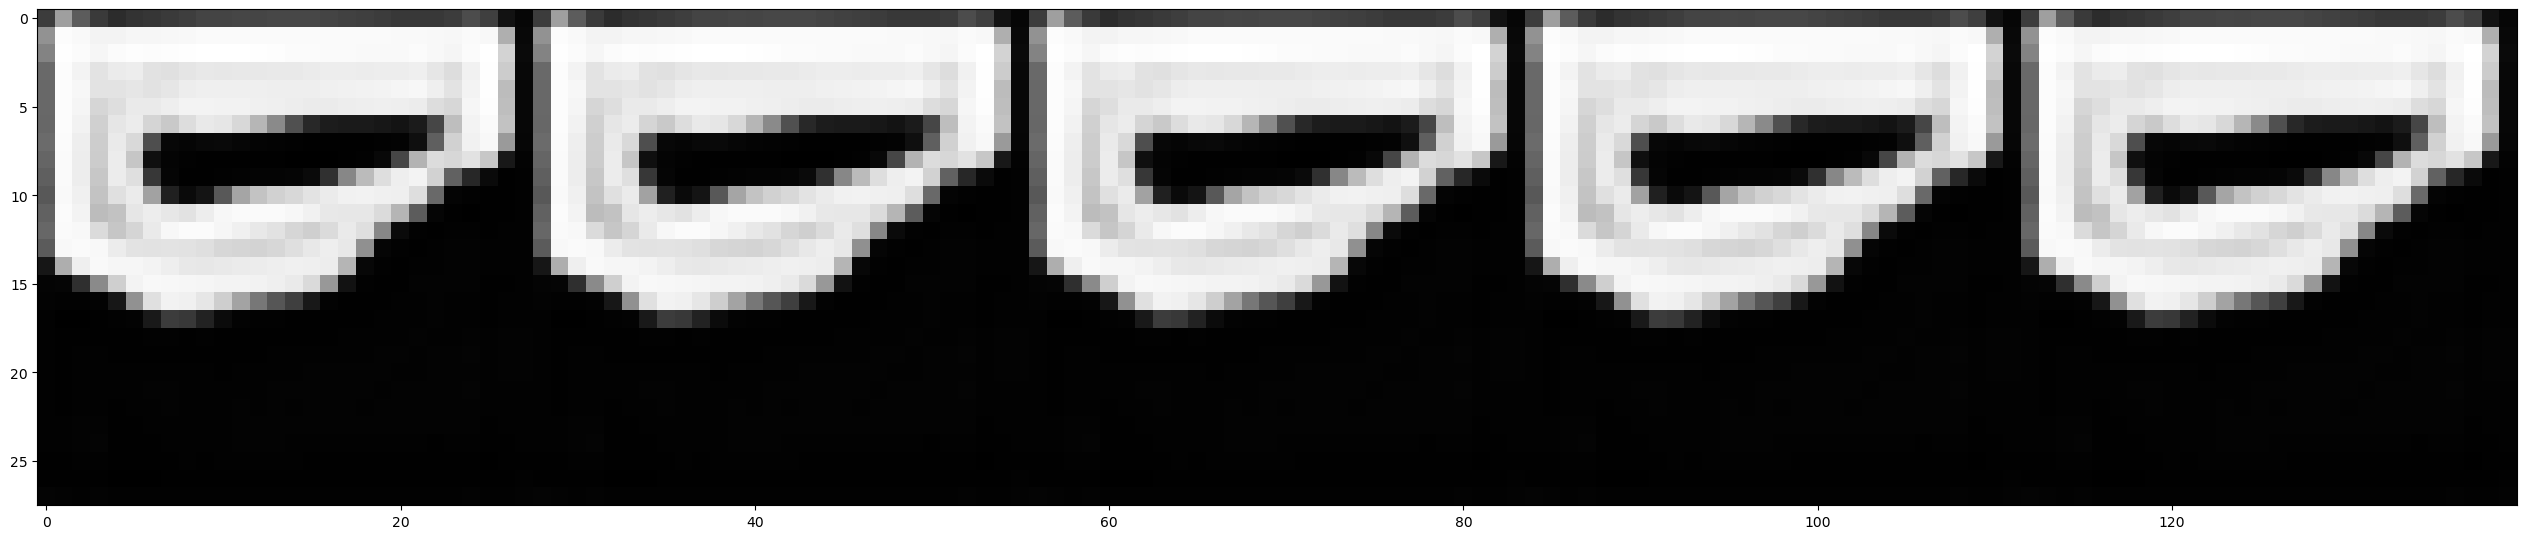

 91%|███████████████████████████████████████████████████████████████████▎      | 91/100 [88:54:21<7:17:18, 2915.38s/it]

Epoch [91/100] | Train Loss: 0.0525 | Validation Loss: 0.0527


 92%|████████████████████████████████████████████████████████████████████      | 92/100 [89:44:50<6:33:15, 2949.39s/it]

Epoch [92/100] | Train Loss: 0.0533 | Validation Loss: 0.0492


 93%|████████████████████████████████████████████████████████████████████▊     | 93/100 [90:32:27<5:40:51, 2921.66s/it]

Epoch [93/100] | Train Loss: 0.0521 | Validation Loss: 0.0509



 44%|███████████████████████████████████▍                                            | 133/300 [00:07<00:09, 18.26it/s]


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [00:14<00:01, 18.34it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 18.23it/s]


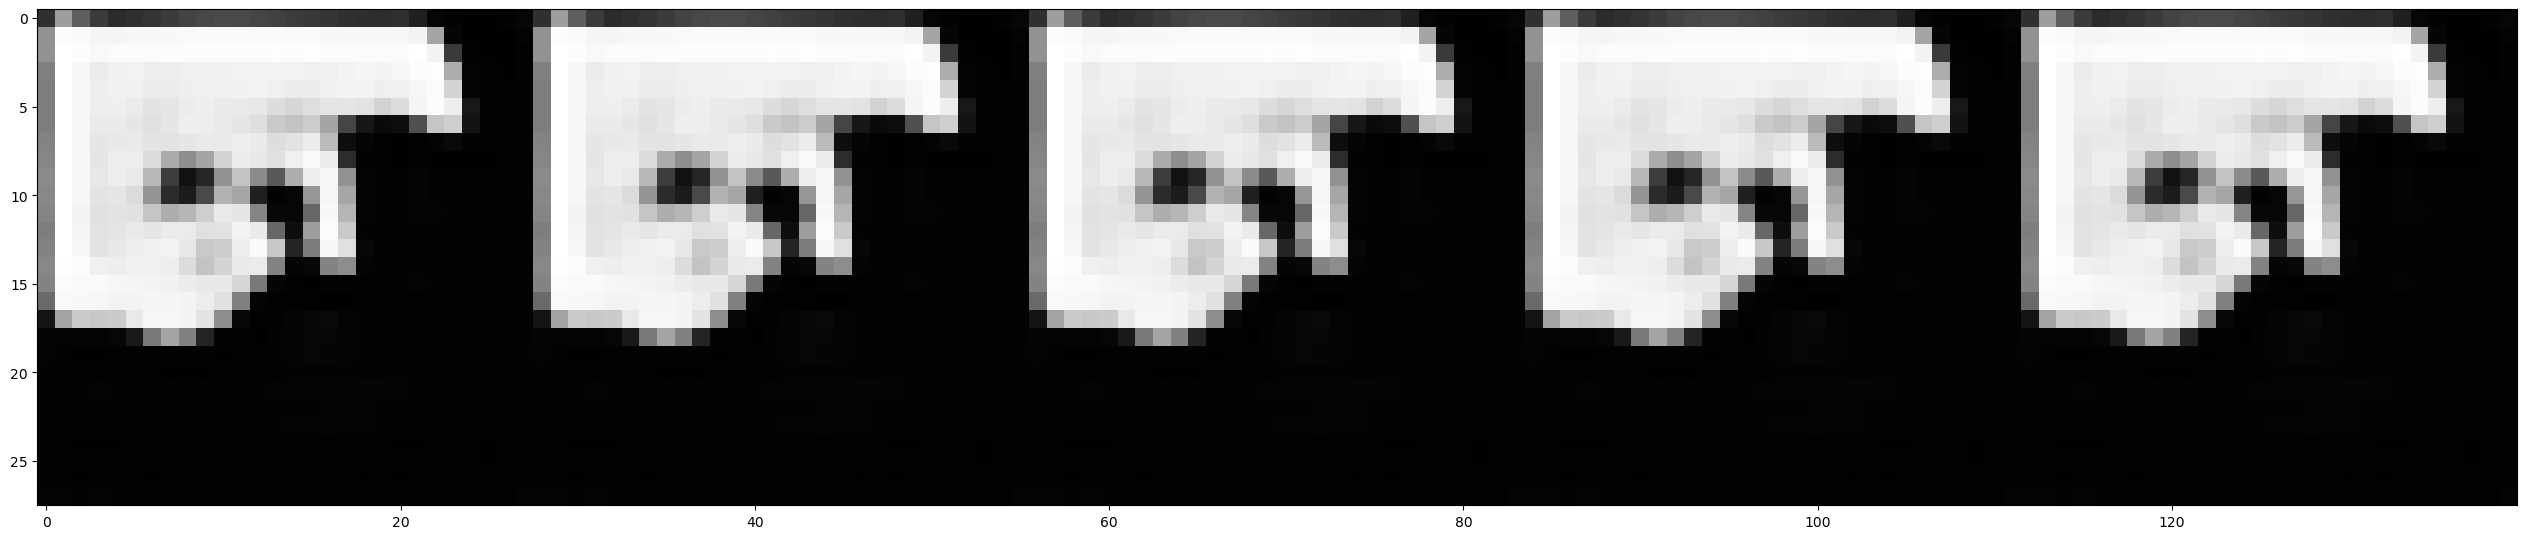

 94%|█████████████████████████████████████████████████████████████████████▌    | 94/100 [91:20:06<4:50:17, 2902.98s/it]

Epoch [94/100] | Train Loss: 0.0519 | Validation Loss: 0.0546


 95%|██████████████████████████████████████████████████████████████████████▎   | 95/100 [92:08:08<4:01:23, 2896.71s/it]

Epoch [95/100] | Train Loss: 0.0512 | Validation Loss: 0.0518


 96%|███████████████████████████████████████████████████████████████████████   | 96/100 [92:56:20<3:13:00, 2895.20s/it]

Epoch [96/100] | Train Loss: 0.0526 | Validation Loss: 0.0490


 96%|███████████████████████████████████████████████████████████████████████   | 96/100 [93:43:22<3:54:18, 3514.61s/it]


KeyboardInterrupt: 

In [81]:
EPOCHS = 100
batch_size = 64
image_size = 28
learning_rate = 3e-4

# Import dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms, download=True)

train_indices, val_indices = split_indices(len(dataset), 0.2)
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
diffusion = coldDiff()
length = len(train_loader)
print(length)

train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t = diffusion.blur(x, t)
        pred = model(x_t, t)
        loss = loss_fn(pred, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for x, _ in val_loader:
            #print(type(x))
            #print(x.shape)
            x = x.to(device)
            t = diffusion.sample_timesteps(x.shape[0]).to(device)
            x_t = diffusion.blur(x, t)
            pred = model(x_t, t)
            batch_val_loss = loss_fn(pred, x)
            val_loss += batch_val_loss.item()
    
    # Sample only every 3 epochs for opt purposes
    if epoch%3 == 0:
        sampled_images = diffusion.sample(model, batch_size=5)
        plot_images(sampled_images)
        
    # Save loss
    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    print(f"Epoch [{epoch+1}/100] | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

In [ ]:
torch.save(model.state_dict(), './Models/DM/coldDiff1')

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.94it/s]


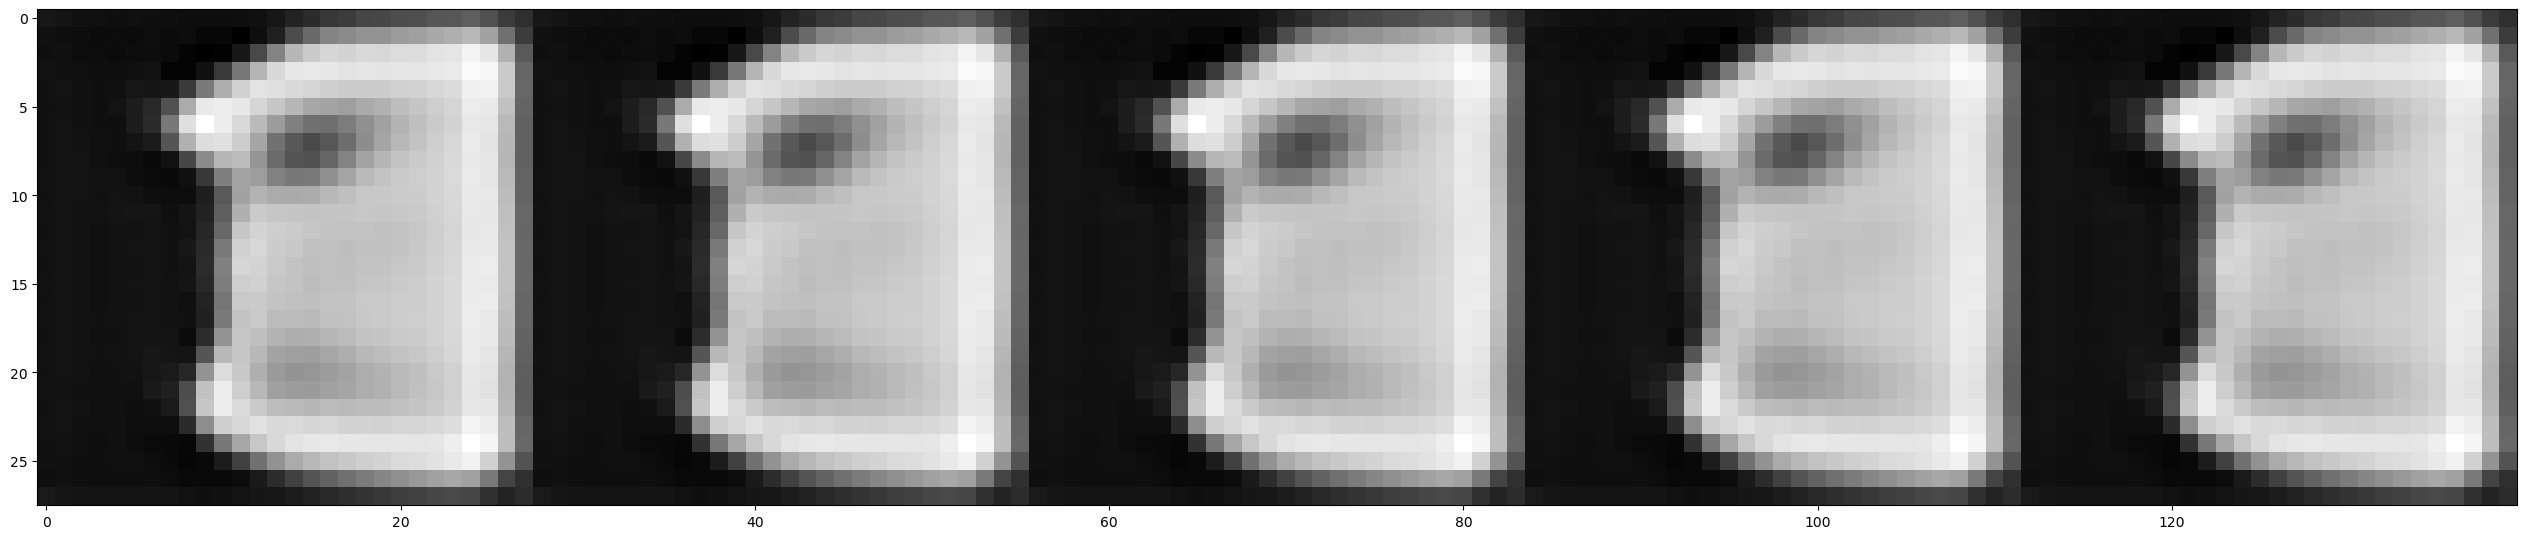

In [69]:
diff2 = coldDiff()
sampled_images = diff2.sample(model, batch_size=5)
plot_images(sampled_images)

In [ ]:
# Manually create loss record since I forgot to add the append.
train_losses = []
val_losses = []

In [ ]:
### Save model
torch.save(model.state_dict(), './Models/DM/diffusion2')

### FID

In [ ]:
from inception import InceptionV3
from torchvision.utils import save_image
from torchvision.models import inception_v3
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm


def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1-mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1+sigma2- 2*covmean)
    return fid

def get_activations(images, model, batch_size=32, dims=2048, device='cuda'):
    model.eval()
    pred_arr = np.empty((len(images), dims))
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            start = i
            end = i+batch_size
            batch = images[start:end].to(device)
            #print(batch.size())
            #raise
            pred = model(batch)[0]
            pred = F.adaptive_avg_pool2d(pred, output_size=(1,1))
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr[start:end] = pred
    return pred_arr

#inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
#inception_model.fc = torch.nn.Identity()
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx]).to(device)

In [40]:
original_images = []
generated_images = []

model.eval()
with torch.no_grad():
    for x, t in train_loader:
        original_images.append(x)
        sampled = diffusion.sample(model, n=x.shape[0])
        generated_images.append(sampled)
        
original_images = torch.stack(original_images)
generated_images = torch.stack(generated_images)

999it [01:06, 14.93it/s]
999it [01:07, 14.79it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.67it/s]
999it [01:09, 14.44it/s]
999it [01:08, 14.52it/s]
999it [01:09, 14.33it/s]
999it [01:09, 14.46it/s]
999it [01:08, 14.56it/s]
999it [01:09, 14.27it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.37it/s]
999it [01:08, 14.57it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.56it/s]
999it [01:11, 13.98it/s]
999it [01:09, 14.41it/s]
999it [01:08, 14.66it/s]
999it [01:07, 14.71it/s]
999it [01:09, 14.32it/s]
999it [01:08, 14.60it/s]
999it [01:08, 14.58it/s]
999it [01:08, 14.55it/s]
999it [01:09, 14.36it/s]
999it [01:08, 14.49it/s]
999it [01:09, 14.39it/s]
999it [01:08, 14.53it/s]
999it [01:10, 14.13it/s]
999it [01:10, 14.15it/s]
999it [01:09, 14.46it/s]
999it [01:10, 14.16it/s]
999it [01:11, 13.98it/s]
999it [01:13, 13.59it/s]
999it [01:15, 13.22it/s]
999it [01:11, 13.94it/s]
999it [01:11, 14.01it/s]
999it [01:11, 13.89it/s]
999it [01:10, 14.09it/s]
999it [01:09, 14.30it/s]
999it [01:08, 14.50it/s]


KeyboardInterrupt: 

In [49]:
generated_images.size()

torch.Size([111, 32, 1, 28, 28])

In [19]:
original_images = torch.stack(original_images[:-1])
generated_images = torch.stack(generated_images)

NameError: name 'original_images' is not defined

In [54]:
transform = torchvision.transforms.Compose([
    #transforms.Grayscale(3)
    torchvision.transforms.Lambda(lambda x: x.repeat(1, 1, 3, 1, 1))
])

original_transformed = []
generated_transformed = []

for i in range(len(generated_images)):
    original_transformed.append(transform(original_images[i].squeeze()))
    generated_transformed.append(transform(generated_images[i].squeeze()))
    
original_transformed = torch.stack(original_transformed)
generated_transformed = torch.stack(generated_transformed)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [50]:
generated_transformed.size()

torch.Size([111, 96, 28, 28])

In [47]:
generated_transformed = generated_transformed/255 - 1

In [48]:
import numpy as np

original_activations = get_activations(original_transformed, inception_model, device=device)
generated_activations = get_activations(generated_transformed, inception_model, device=device)

# Calculate mean and covariance of the activations
mu1 = np.mean(original_activations, axis=0)
sigma1 = np.cov(original_activations, rowvar=False)
mu2 = np.mean(generated_activations, axis=0)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print('FID score:', fid_score)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 96, 299, 299] to have 3 channels, but got 96 channels instead